In [167]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats
import plotly
import plotly.express as px

## Обработка пропусков и выбросов

In [168]:
#Чтение файла
df = pd.read_csv(r'd:\IDE_github\ML\ML_project4\data\bank_fin.csv', sep = ';')

In [169]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes


### Обарботка пропусков

In [170]:
#Столбцы с пропусками
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [171]:
#Количество пропусков
df.isna().sum().loc['balance']

np.int64(25)

In [172]:
#Исследование столбца job на количество пропусков
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [173]:
#Исследование столбца education на количество пропусков
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

Пропуск обозначен за unknown

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [175]:
#Тип данных object
df['balance'].head(3)

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
Name: balance, dtype: object

In [176]:
#Разделяем столбец balance на числовое значение и валюту
df[['balance_value', 'currency']] = df['balance'].str.extract(r'([\d,]+)\s*(\D+)')

In [177]:
#Преобразуем числовое значение в float (заменяем запятую на точку)
df['balance_value'] = df['balance_value'].str.replace(',', '.').astype(float)

In [178]:
#Удаляем исходный столбец balance и currency, так большая часть данных в одной валюте
df = df.drop(['balance','currency'], axis=1)

In [179]:
#Заменяем пропуски в balance_value медианным значением
df['balance_value'] = df['balance_value'].fillna(df['balance_value'].median())

In [180]:
#Заменяем пропуски в признаках job и education на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

### Обработка выбросов

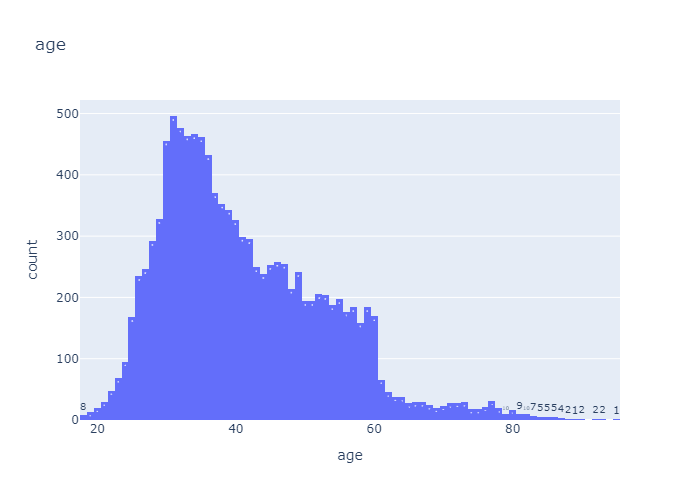

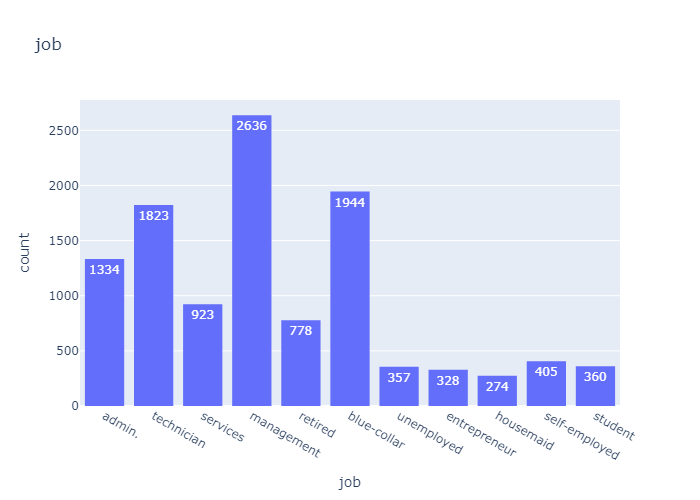

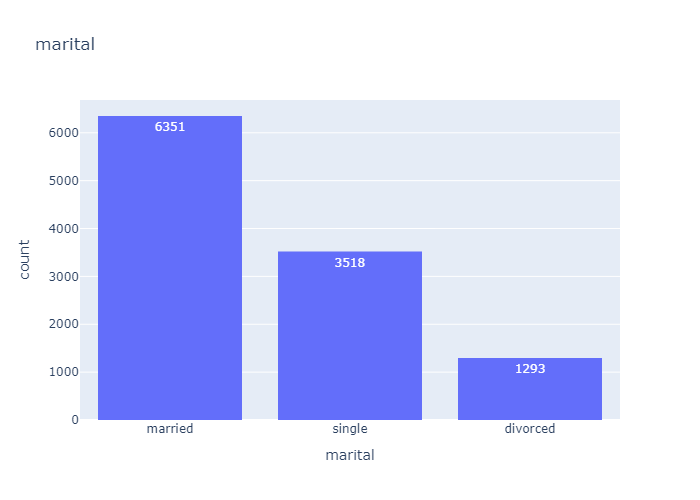

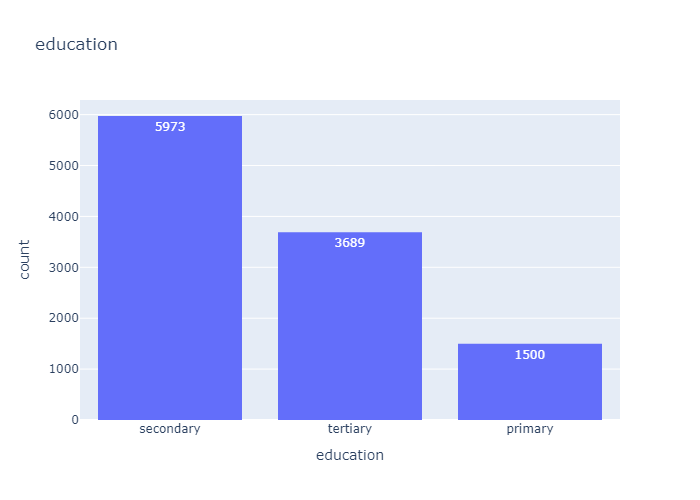

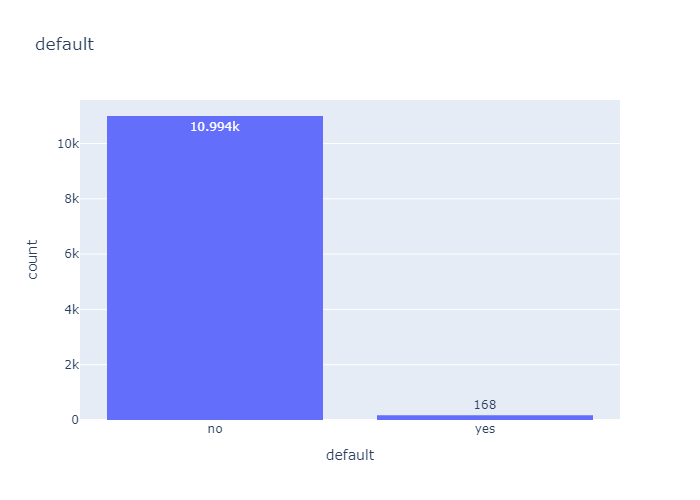

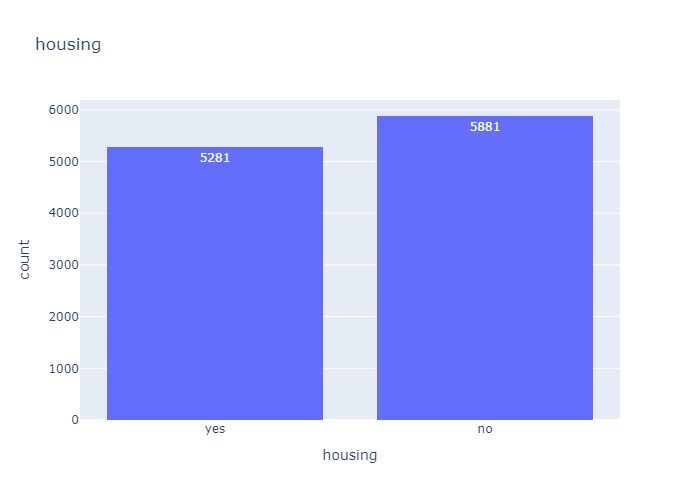

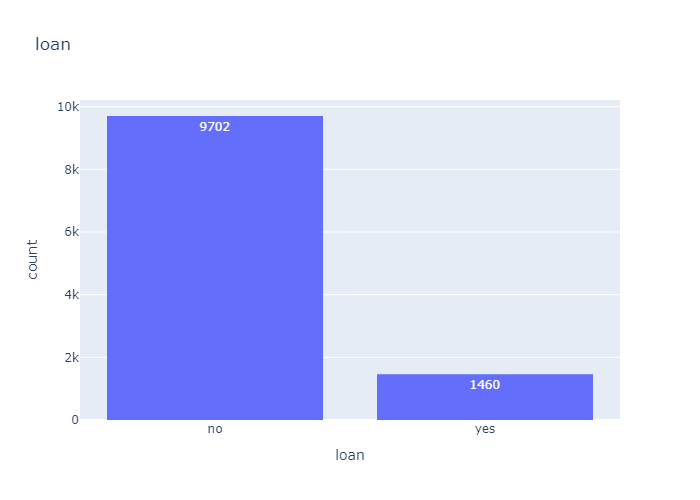

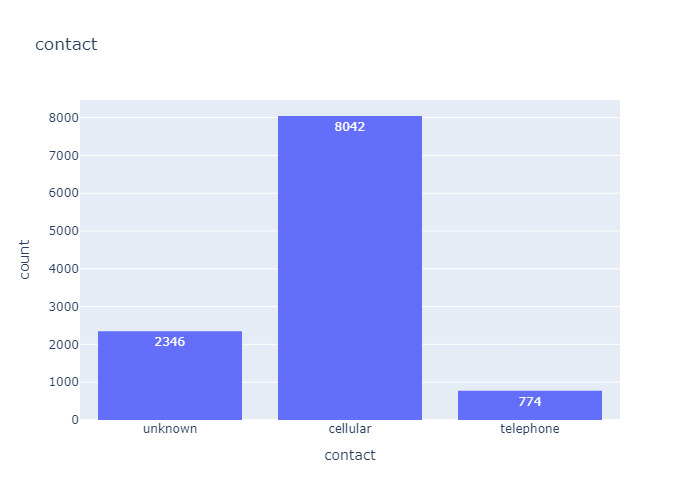

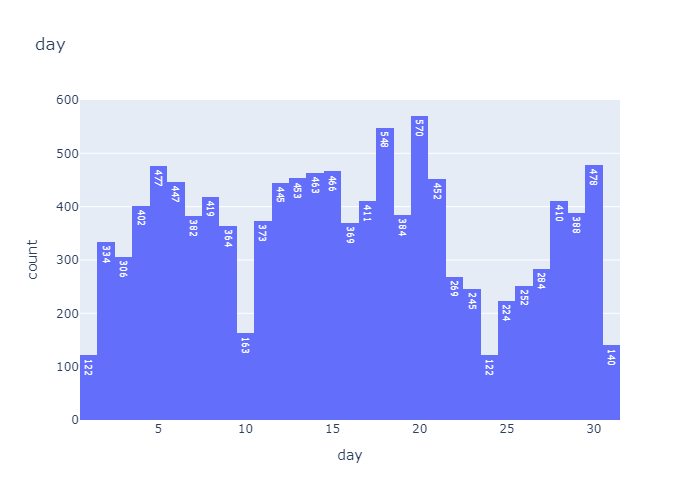

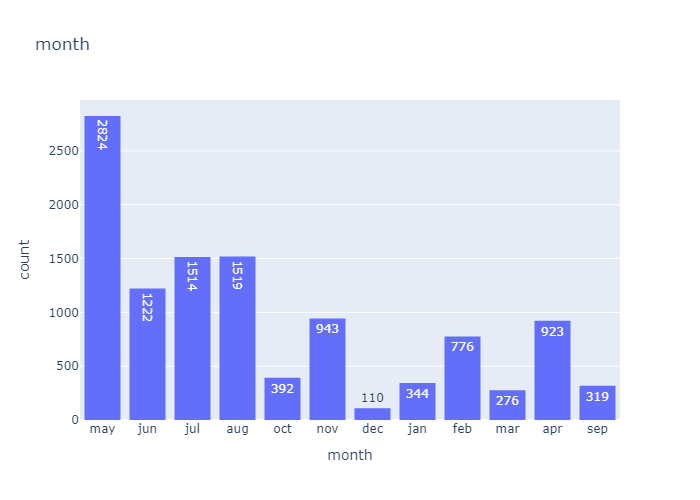

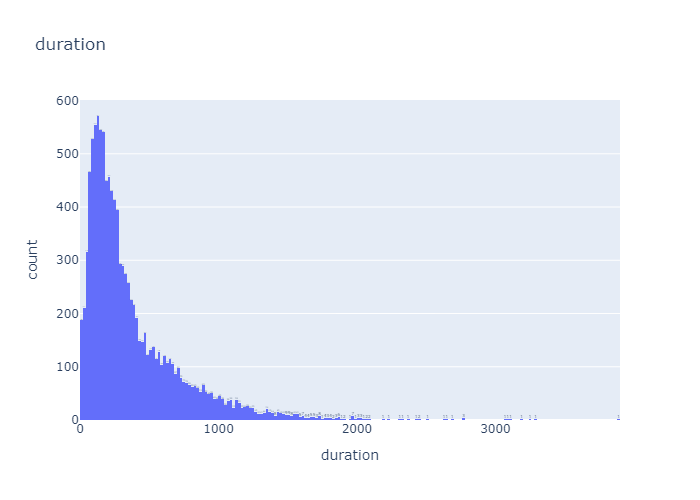

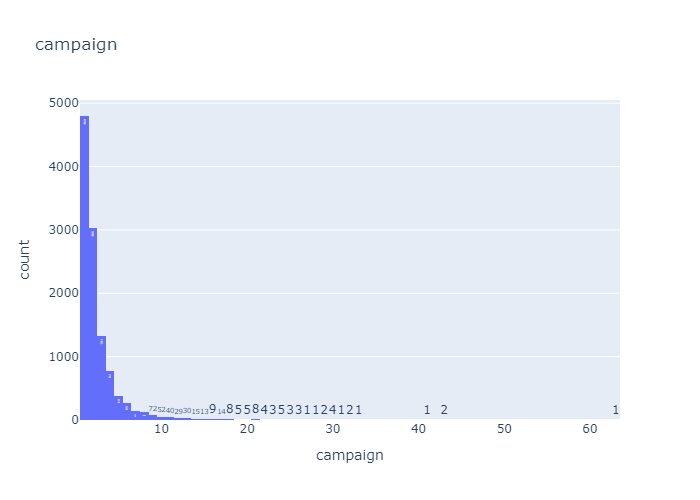

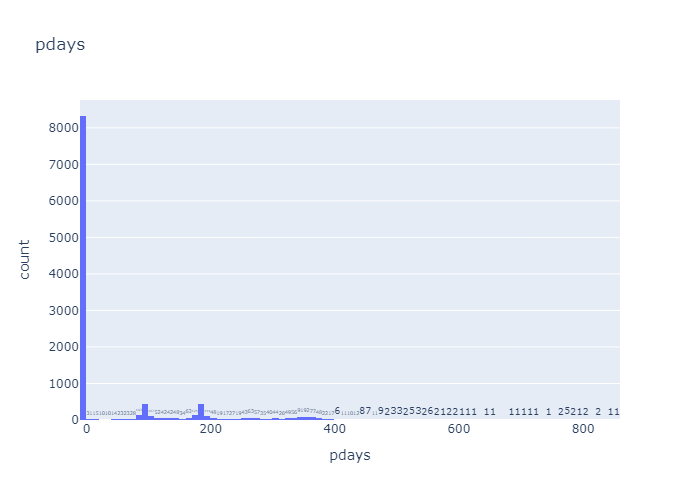

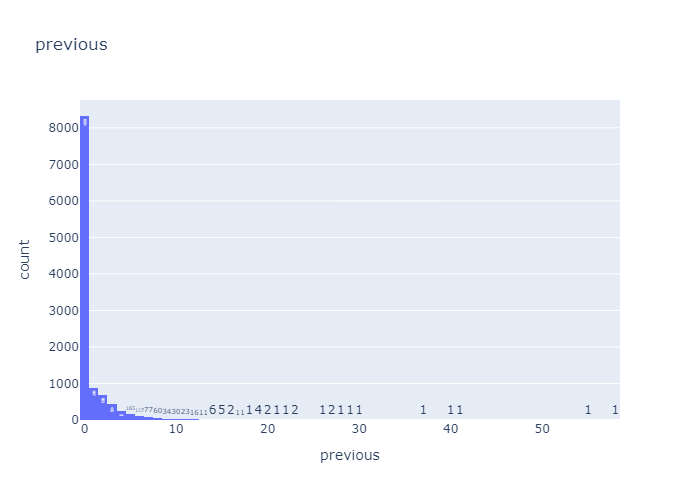

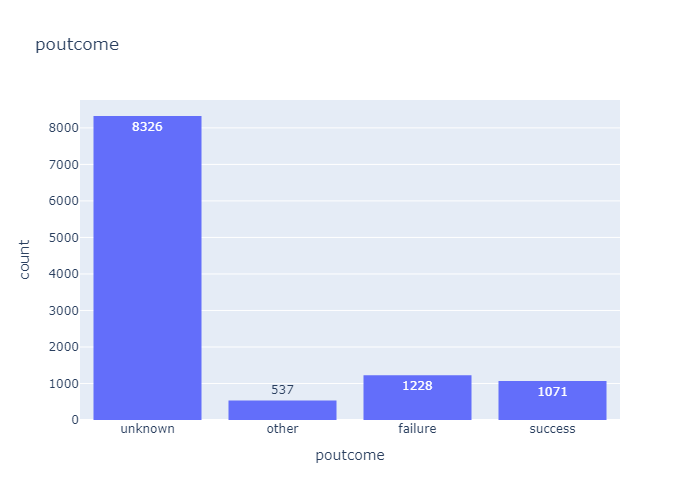

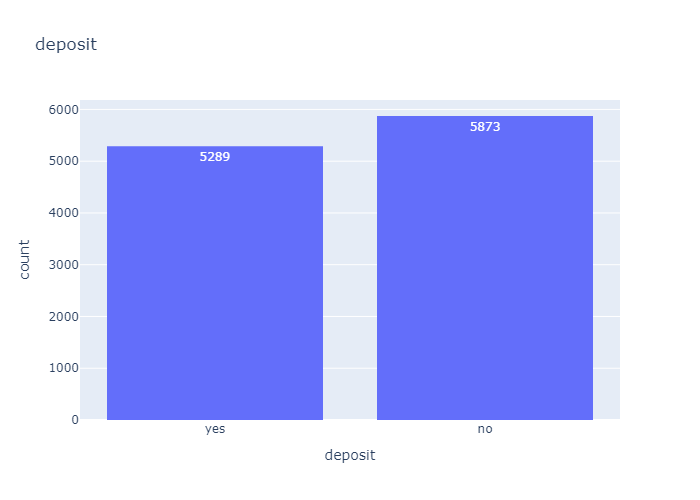

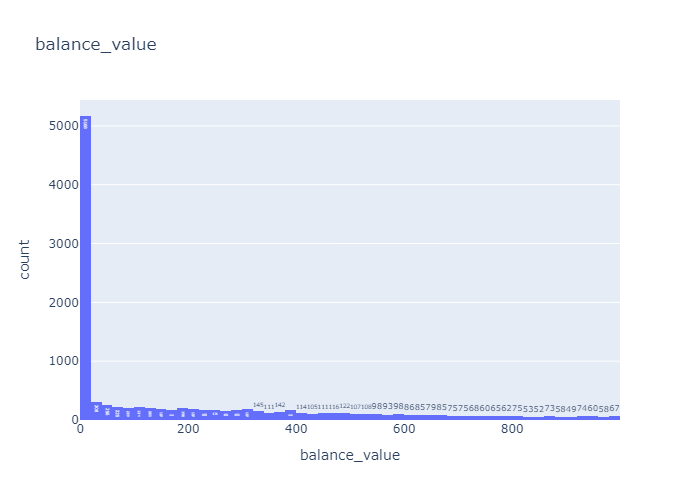

In [181]:
#Гистрограммы данных
for i in list(df.columns):
    fig = px.histogram(df, x=i, title=i, text_auto=True)
    fig.show('png')

При таком boxplot межквартальный размах (IQR) неоптимален, используем Z-score

In [182]:
#Вычисляем z-scores для balance_value
z_scores = np.abs(stats.zscore(df['balance_value']))
#Устанавливаем порог
threshold = 9
#Удаляем выбросы
df_clean = df[z_scores < threshold]
# роверяем сколько данных удалилось
print(f'Исходный размер: {len(df)} записей')
print(f'После очистки: {len(df_clean)} записей')
print(f'Удалено {len(df) - len(df_clean)} выбросов ({((len(df) - len(df_clean))/len(df))*100:.2f}% данных)')

Исходный размер: 11162 записей
После очистки: 11162 записей
Удалено 0 выбросов (0.00% данных)


In [183]:
#Логарифмическое преобразование + IQR
df_log = df.copy()
df_log['balance_log'] = np.log1p(df_log['balance_value'])  #log(1+x) для обработки нулей
Q1_log = df_log['balance_log'].quantile(0.25)
Q3_log = df_log['balance_log'].quantile(0.75)
IQR_log = Q3_log - Q1_log
df_clean = df[(df_log['balance_log'] >= Q1_log - 1.5*IQR_log) & 
              (df_log['balance_log'] <= Q3_log + 1.5*IQR_log)]
#Проверяем сколько данных удалилось
print(f'Исходный размер: {len(df)} записей')
print(f'После очистки: {len(df_clean)} записей')
print(f'Удалено {len(df) - len(df_clean)} выбросов ({((len(df) - len(df_clean))/len(df))*100:.2f}% данных)')

Исходный размер: 11162 записей
После очистки: 11162 записей
Удалено 0 выбросов (0.00% данных)


In [184]:
#Процентили
lower_bound = df['balance_value'].quantile(0.01)
upper_bound = df['balance_value'].quantile(0.99)
df_clean = df[(df['balance_value'] >= lower_bound) & (df['balance_value'] <= upper_bound)]
#Проверяем сколько данных удалилось
print(f'Исходный размер: {len(df)} записей')
print(f'После очистки: {len(df_clean)} записей')
print(f'Удалено {len(df) - len(df_clean)} выбросов ({((len(df) - len(df_clean))/len(df))*100:.2f}% данных)')

Исходный размер: 11162 записей
После очистки: 11050 записей
Удалено 112 выбросов (1.00% данных)


In [185]:
#Удаление с помощью метода Тьюки
#Вычисляем квартили используя np.percentile()
Q1 = np.percentile(df['balance_value'], 25)  # Нижний квартиль (25-й перцентиль)
Q3 = np.percentile(df['balance_value'], 75)  # Верхний квартиль (75-й перцентиль)
IQR = Q3 - Q1  # Межквартильный размах
#Определяем границы по методу Тьюки
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Q1 (25-й перцентиль): {Q1}")
print(f"Q3 (75-й перцентиль): {Q3}")
print(f"IQR (межквартильный размах): {IQR}")
print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")
#Находим выбросы
outliers = df[(df['balance_value'] < lower_bound) | (df['balance_value'] > upper_bound)]
print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов: {len(outliers)/len(df)*100:.2f}%")
#Удаляем выбросы (фильтрация с пересечением двух условий)
df_clean = df[(df['balance_value'] >= lower_bound) & (df['balance_value'] <= upper_bound)]
#Вычисляем количество оставшихся объектов
remaining_count = len(df_clean)
removed_count = len(df) - remaining_count
print(f"Исходное количество объектов: {len(df)}")
print(f"Количество выбросов: {removed_count}")
print(f"Объектов осталось после удаления выбросов: {remaining_count}")
print(f"Процент удаленных данных: {removed_count/len(df)*100:.2f}%")

Q1 (25-й перцентиль): 2.0
Q3 (75-й перцентиль): 349.0
IQR (межквартильный размах): 347.0
Нижняя граница: -518.5
Верхняя граница: 869.5
Количество выбросов: 407
Процент выбросов: 3.65%
Исходное количество объектов: 11162
Количество выбросов: 407
Объектов осталось после удаления выбросов: 10755
Процент удаленных данных: 3.65%


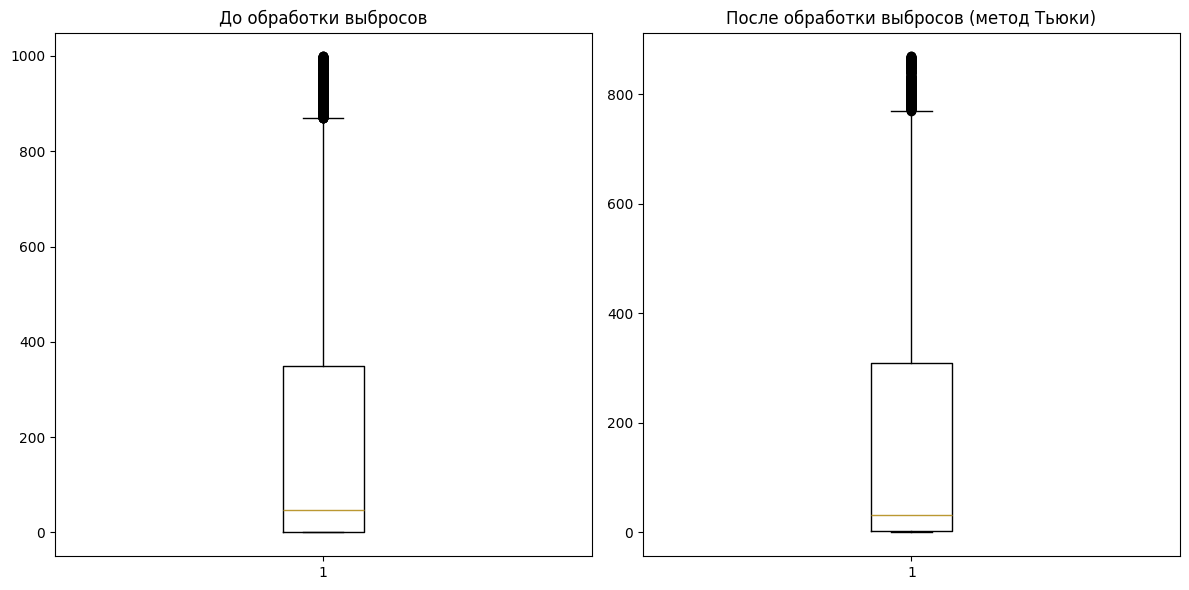

In [186]:
plt.figure(figsize=(12, 6))
#Boxplot до обработки
plt.subplot(1, 2, 1)
plt.boxplot(df['balance_value'])
plt.title('До обработки выбросов')
#Boxplot после обработки
plt.subplot(1, 2, 2)
plt.boxplot(df_clean['balance_value'])
plt.title('После обработки выбросов (метод Тьюки)')
plt.tight_layout()
plt.show()

In [187]:
df = df_clean

## Разведывательный анализ данных

Распределение классов:
deposit
no     5672
yes    5083
Name: count, dtype: int64

Процентное соотношение:
deposit
no    52.74
yes   47.26
Name: proportion, dtype: float64


Text(0, 0.5, 'Количество наблюдений')

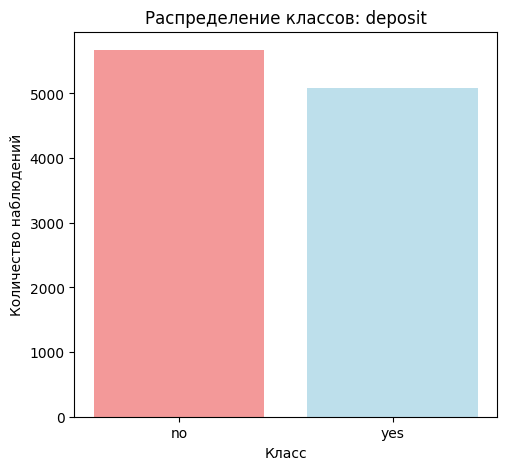

In [188]:
#Изучаем соотношение классов в целевой переменной deposit
class_distribution = df['deposit'].value_counts()
class_percentage = df['deposit'].value_counts(normalize=True) * 100
print("Распределение классов:")
print(class_distribution)
print("\nПроцентное соотношение:")
print(class_percentage)
#Визуализация
plt.figure(figsize=(12, 5))
#Столбчатая диаграмма
plt.subplot(1, 2, 1)
bars = plt.bar(class_distribution.index, class_distribution.values, 
               color=['lightcoral', 'lightblue'], alpha=0.8)
plt.title('Распределение классов: deposit')
plt.xlabel('Класс')
plt.ylabel('Количество наблюдений')

### Описательная статистика числовых данных

In [189]:
#Выбираем только количественные переменные
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("Количественные переменные в dataset:")
print(numeric_columns.tolist())
print()
#Рассчитываем описательные статистики
descriptive_stats = df[numeric_columns].describe().T
# Добавляем дополнительные статистики
descriptive_stats['range'] = descriptive_stats['max'] - descriptive_stats['min']
descriptive_stats['coefficient_of_variation'] = (descriptive_stats['std'] / descriptive_stats['mean']) * 100
descriptive_stats['skewness'] = df[numeric_columns].skew()
descriptive_stats['kurtosis'] = df[numeric_columns].kurtosis()
descriptive_stats['missing_values'] = df[numeric_columns].isnull().sum()
#Форматируем вывод
pd.set_option('display.float_format', '{:.2f}'.format)
print(descriptive_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 
                         'range', 'coefficient_of_variation', 'skewness', 'kurtosis', 'missing_values']])

Количественные переменные в dataset:
['age', 'day', 'duration', 'campaign', 'pdays', 'previous', 'balance_value']

                 count   mean    std   min    25%    50%    75%     max  \
age           10755.00  41.26  11.93 18.00  32.00  39.00  49.00   95.00   
day           10755.00  15.66   8.41  1.00   8.00  15.00  22.00   31.00   
duration      10755.00 372.59 348.15  3.00 138.00 255.00 498.00 3881.00   
campaign      10755.00   2.51   2.72  1.00   1.00   2.00   3.00   63.00   
pdays         10755.00  51.12 108.55 -1.00  -1.00  -1.00   9.50  854.00   
previous      10755.00   0.83   2.29  0.00   0.00   0.00   1.00   58.00   
balance_value 10755.00 177.22 237.13  0.00   2.00  31.00 309.00  869.00   

                range  coefficient_of_variation  skewness  kurtosis  \
age             77.00                     28.90      0.86      0.63   
day             30.00                     53.73      0.11     -1.06   
duration      3878.00                     93.44      2.15      7.39   


### Описательная статистика категориальных переменных


 Переменная: JOB
   • Уникальных значений: 11
   • Мода: 'management' (частота: 2556, 23.8%)
   • Пропущенные значения: 0
   • Распределение:
     - management: 2556 (23.8%)
     - blue-collar: 1873 (17.4%)
     - technician: 1743 (16.2%)
     - admin.: 1269 (11.8%)
     - services: 888 (8.3%)
     - retired: 757 (7.0%)
     - self-employed: 397 (3.7%)
     - student: 355 (3.3%)
     - unemployed: 334 (3.1%)
     - entrepreneur: 319 (3.0%)
     - housemaid: 264 (2.5%)

 Переменная: MARITAL
   • Уникальных значений: 3
   • Мода: 'married' (частота: 6114, 56.8%)
   • Пропущенные значения: 0
   • Распределение:
     - married: 6114 (56.8%)
     - single: 3390 (31.5%)
     - divorced: 1251 (11.6%)

 Переменная: EDUCATION
   • Уникальных значений: 3
   • Мода: 'secondary' (частота: 5732, 53.3%)
   • Пропущенные значения: 0
   • Распределение:
     - secondary: 5732 (53.3%)
     - tertiary: 3567 (33.2%)
     - primary: 1456 (13.5%)

 Переменная: DEFAULT
   • Уникальных значений: 2
   • Мода

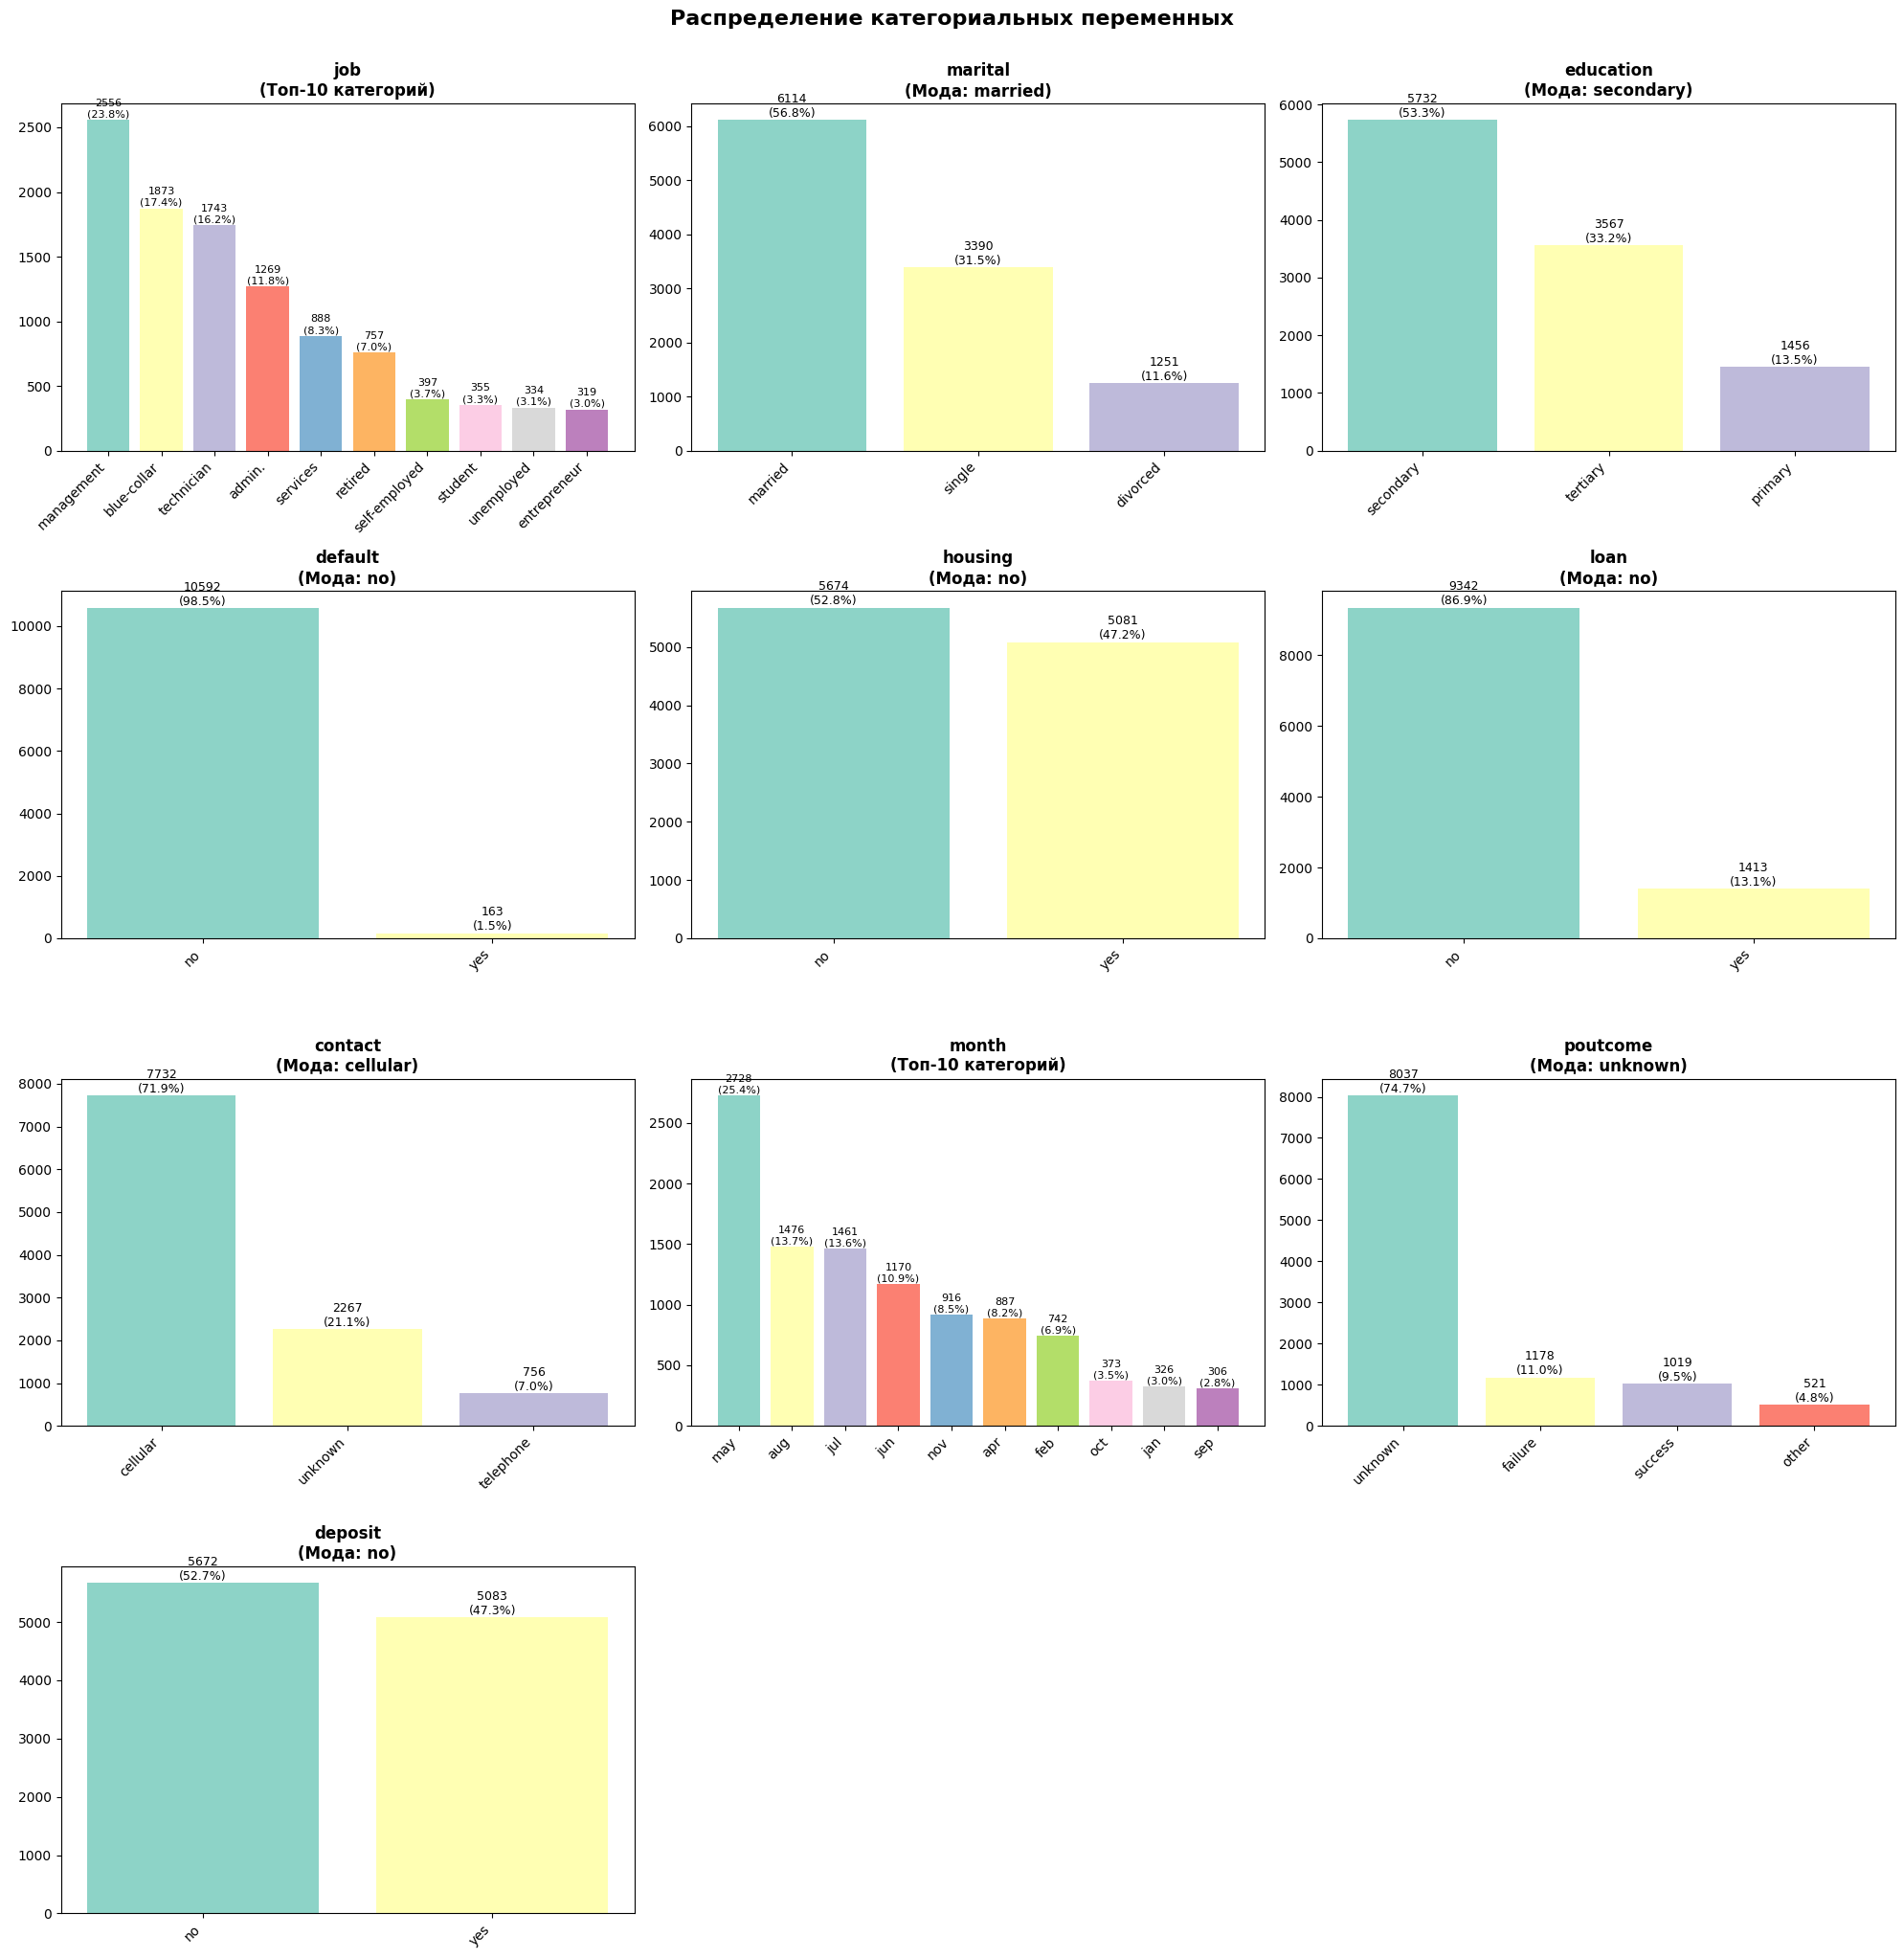

In [190]:
#Установка стиля графиков
plt.style.use('default')
sns.set_palette("husl")
#Категориальные переменные
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'poutcome', 'deposit']
#Создаем subplot сетку
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    if i < len(axes):
        #Рассчитываем статистики
        value_counts = df[col].value_counts()
        percentages = df[col].value_counts(normalize=True) * 100
        mode_value = value_counts.index[0]
        mode_count = value_counts.iloc[0]
        mode_percentage = percentages.iloc[0]
        unique_count = df[col].nunique()
        missing_count = df[col].isnull().sum()
        #Выводим статистики
        print(f"\n Переменная: {col.upper()}")
        print(f"   • Уникальных значений: {unique_count}")
        print(f"   • Мода: '{mode_value}' (частота: {mode_count}, {mode_percentage:.1f}%)")
        print(f"   • Пропущенные значения: {missing_count}")
        print(f"   • Распределение:")
        for val, count, perc in zip(value_counts.index, value_counts.values, percentages.values):
            print(f"     - {val}: {count} ({perc:.1f}%)")
        #Визуализаци
        if unique_count <= 10:  # Для переменных с небольшим количеством категорий
            bars = axes[i].bar(range(len(value_counts)), value_counts.values, 
                              color=plt.cm.Set3(np.arange(len(value_counts))))
            axes[i].set_title(f'{col}\n(Мода: {mode_value})', fontsize=12, fontweight='bold')
            axes[i].set_xticks(range(len(value_counts)))
            axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
            #Добавляем значения на столбцы
            for bar, count, perc in zip(bars, value_counts.values, percentages.values):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 5,
                           f'{count}\n({perc:.1f}%)', ha='center', va='bottom', fontsize=9)
        else:  #Для переменных с большим количеством категорий (топ-10)
            top_10 = value_counts.head(10)
            bars = axes[i].bar(range(len(top_10)), top_10.values, 
                              color=plt.cm.Set3(np.arange(len(top_10))))
            axes[i].set_title(f'{col}\n(Топ-10 категорий)', fontsize=12, fontweight='bold')
            axes[i].set_xticks(range(len(top_10)))
            axes[i].set_xticklabels(top_10.index, rotation=45, ha='right')
            for bar, count, perc in zip(bars, top_10.values, (top_10/len(df)*100).values):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 5,
                           f'{count}\n({perc:.1f}%)', ha='center', va='bottom', fontsize=8)
#Скрываем лишние subplots
for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.suptitle('Распределение категориальных переменных', fontsize=16, fontweight='bold', y=1.02)
plt.show()

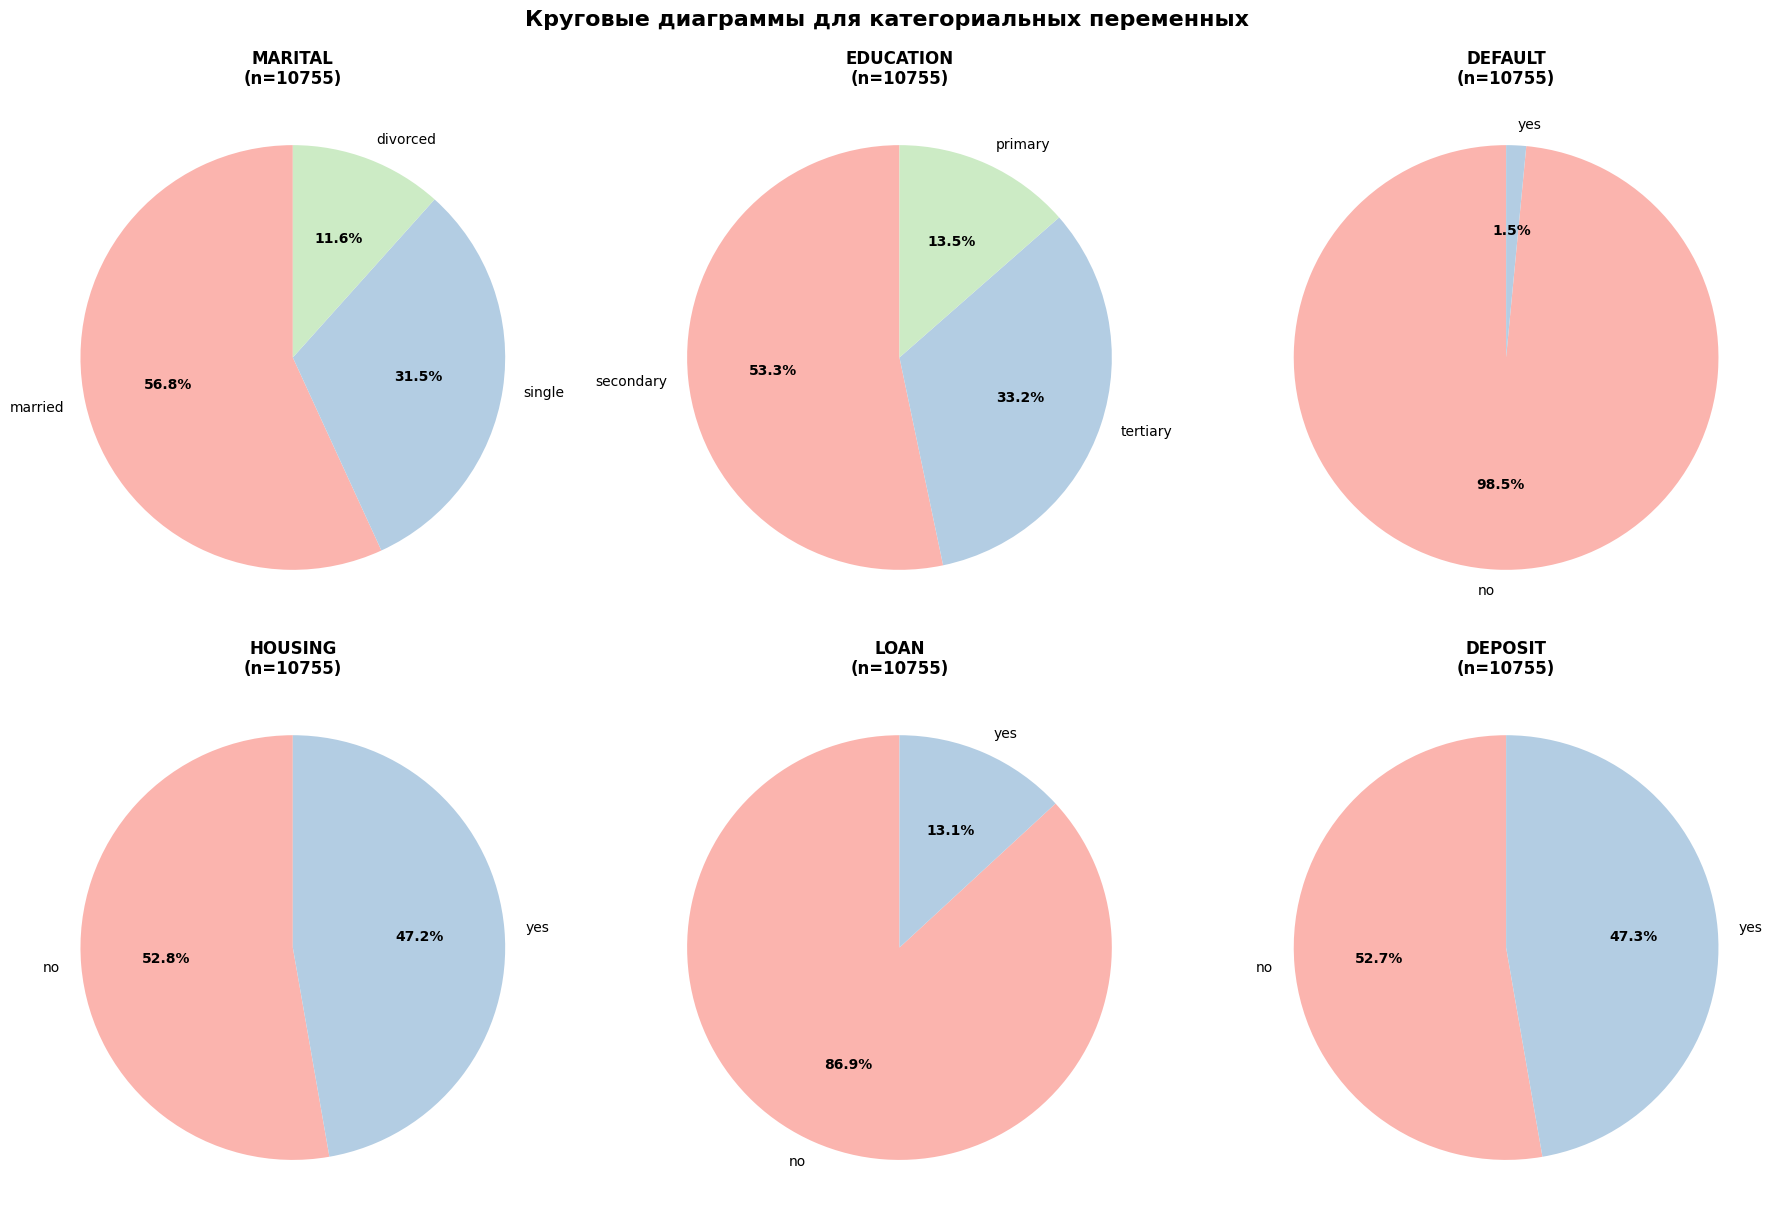

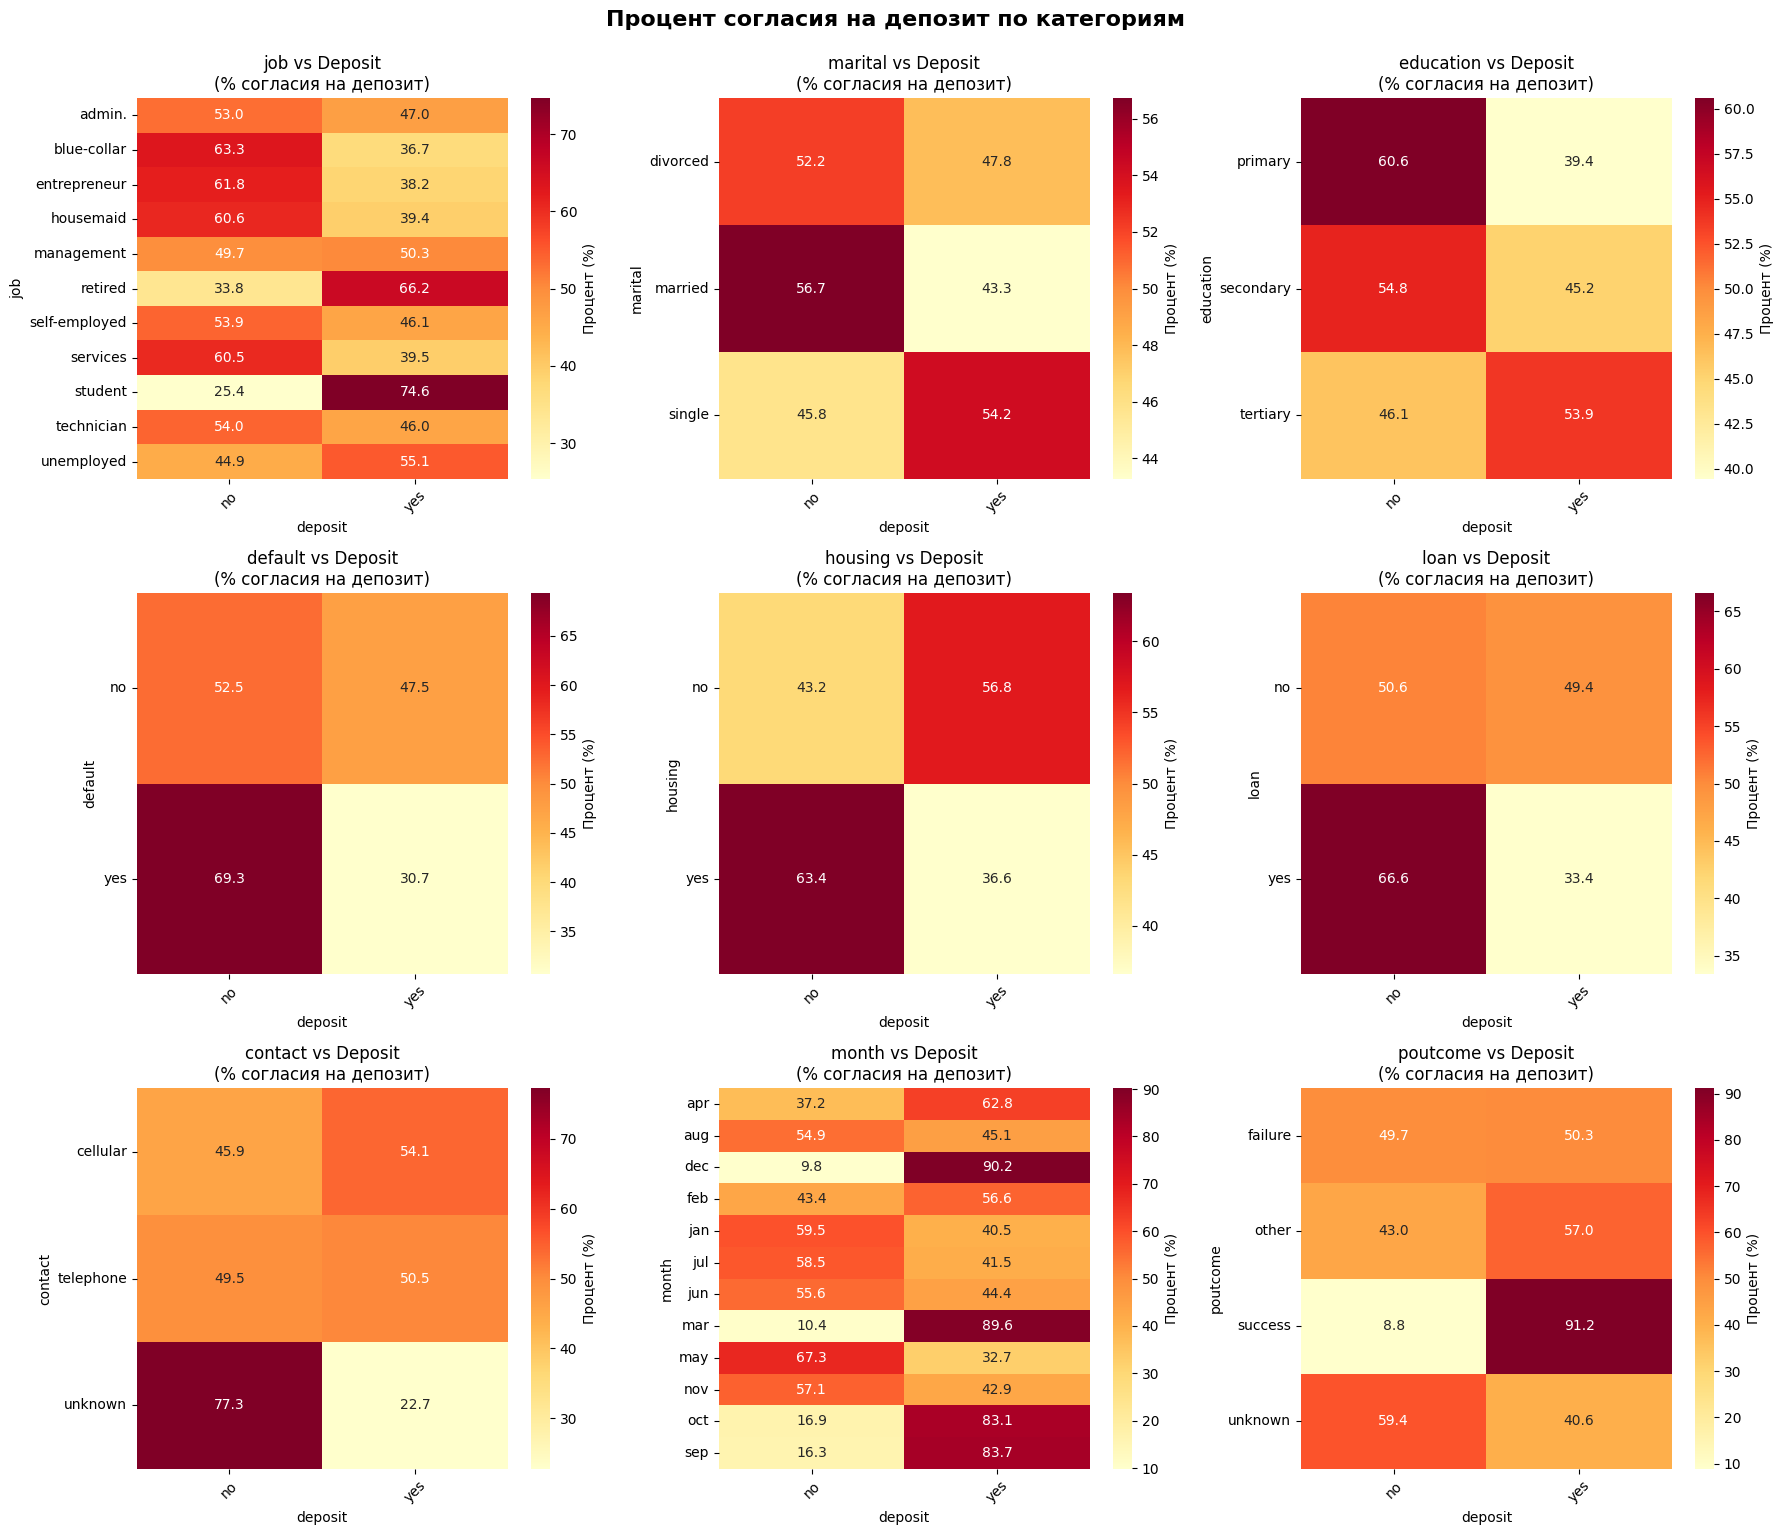

In [191]:
#Круговые диаграммы для ключевых переменных
key_categorical = ['marital', 'education', 'default', 'housing', 'loan', 'deposit']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(key_categorical):
    if i < len(axes):
        value_counts = df[col].value_counts()
        wedges, texts, autotexts = axes[i].pie(value_counts.values, 
                                              labels=value_counts.index,
                                              autopct='%1.1f%%',
                                              startangle=90,
                                              colors=plt.cm.Pastel1(np.arange(len(value_counts))))
        axes[i].set_title(f'{col.upper()}\n(n={len(df[col].dropna())})', fontweight='bold')
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
plt.tight_layout()
plt.suptitle('Круговые диаграммы для категориальных переменных', fontsize=16, fontweight='bold', y=1.02)
plt.show()
#Heatmap для анализа взаимосвязей категориальных переменных с целевой
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()
for i, col in enumerate(categorical_cols[:-1]):  # Все кроме deposit
    if i < len(axes):
        cross_tab = pd.crosstab(df[col], df['deposit'], normalize='index') * 100
        sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Процент (%)'}, ax=axes[i])
        axes[i].set_title(f'{col} vs Deposit\n(% согласия на депозит)')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.suptitle('Процент согласия на депозит по категориям', fontsize=16, fontweight='bold', y=1.02)
plt.show()

Доля согласий на депозит в зависимости от результата прошлой кампании:
          Not Subscribed (%)  Subscribed (%)
poutcome                                    
failure                49.75           50.25
other                  42.99           57.01
success                 8.83           91.17
unknown                59.38           40.62


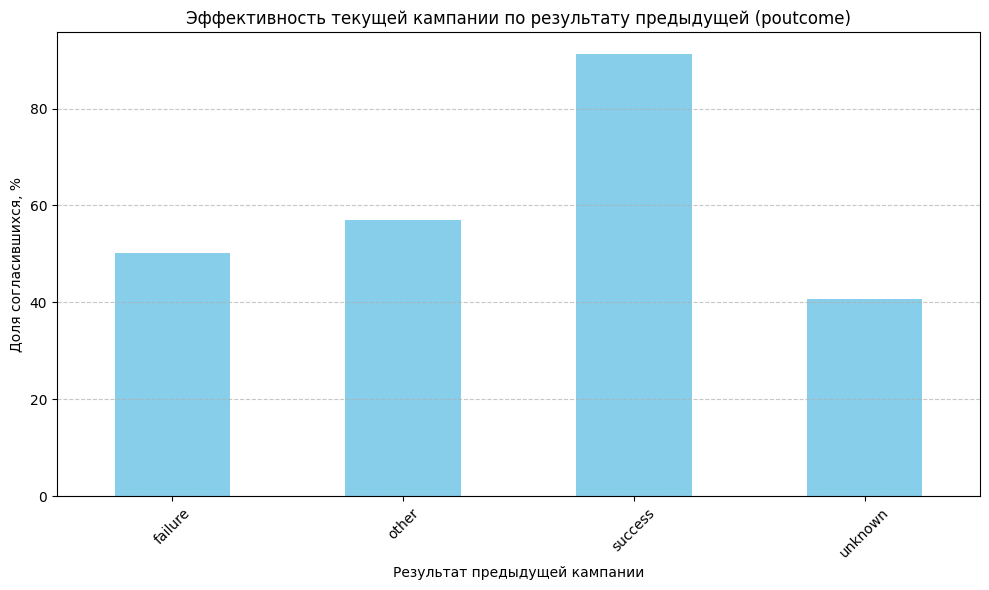

In [192]:
#Создаем таблицу сопряженности
contingency_table = pd.crosstab(df['poutcome'], df['deposit'], normalize='index') * 100
#Переименовываем колонки для читаемости (если нужно)
contingency_table.columns = ['Not Subscribed (%)', 'Subscribed (%)']
print("Доля согласий на депозит в зависимости от результата прошлой кампании:")
print(contingency_table.round(2))
#Визуализация
plt.figure(figsize=(10, 6))
contingency_table['Subscribed (%)'].plot(kind='bar', color='skyblue')
plt.title('Эффективность текущей кампании по результату предыдущей (poutcome)')
plt.ylabel('Доля согласившихся, %')
plt.xlabel('Результат предыдущей кампании')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Количество отказов по месяцам:
month
may    1837
jul     855
aug     810
jun     650
nov     523
apr     330
feb     322
jan     194
oct      63
sep      50
mar      28
dec      10
Name: count, dtype: int64

Чаще всего отказывались от предложения открыть депозит в месяце: may
Количество отказов: 1837


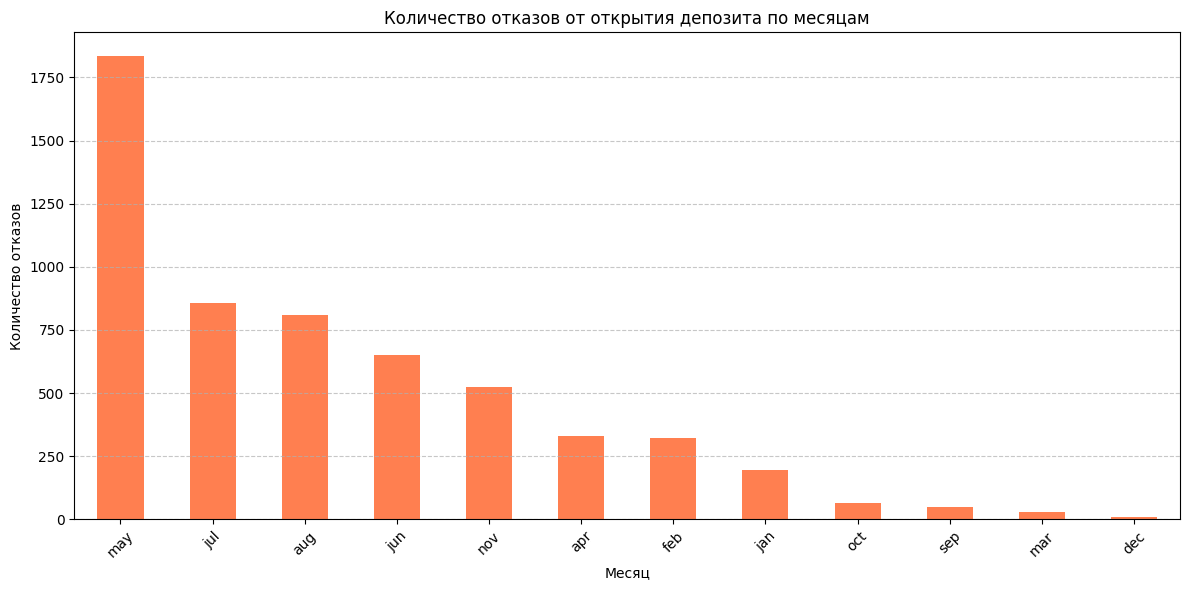


Доля отказов по месяцам (% от всех контактов в месяце):
month
apr   37.20
aug   54.88
dec    9.80
feb   43.40
jan   59.51
jul   58.52
jun   55.56
mar   10.45
may   67.34
nov   57.10
oct   16.89
sep   16.34
Name: count, dtype: float64

Наибольшая доля отказов в месяце: may (67.34%)


In [193]:
#Фильтруем только тех, кто отказался от депозита (deposit = 'no')
refused_clients = df[df['deposit'] == 'no']
#Считаем количество отказов по месяцам
monthly_refusals = refused_clients['month'].value_counts()
print("Количество отказов по месяцам:")
print(monthly_refusals)
#Находим месяц с максимальным количеством отказов
max_refusal_month = monthly_refusals.idxmax()
max_refusal_count = monthly_refusals.max()
print(f"\nЧаще всего отказывались от предложения открыть депозит в месяце: {max_refusal_month}")
print(f"Количество отказов: {max_refusal_count}")
#Визуализация
plt.figure(figsize=(12, 6))
monthly_refusals.plot(kind='bar', color='coral')
plt.title('Количество отказов от открытия депозита по месяцам')
plt.ylabel('Количество отказов')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
#Дополнительно: посмотрим долю отказов от общего числа контактов в каждом месяце
monthly_total = df['month'].value_counts()
monthly_refusal_rate = (refused_clients['month'].value_counts() / monthly_total * 100).sort_index()
print("\nДоля отказов по месяцам (% от всех контактов в месяце):")
print(monthly_refusal_rate.round(2))
#Месяц с наибольшей долей отказов
max_refusal_rate_month = monthly_refusal_rate.idxmax()
max_refusal_rate = monthly_refusal_rate.max()
print(f"\nНаибольшая доля отказов в месяце: {max_refusal_rate_month} ({max_refusal_rate:.2f}%)")

Распределение по возрастным группам:
age_group
30-40    4159
40-50    2531
50-60    1826
60+       750
<30      1489
Name: count, dtype: int64

Доля согласий на депозит по возрастным группам:
           Отказ (%)  Согласие (%)
age_group                         
30-40          55.90         44.10
40-50          59.58         40.42
50-60          58.49         41.51
60+            23.33         76.67
<30            40.03         59.97


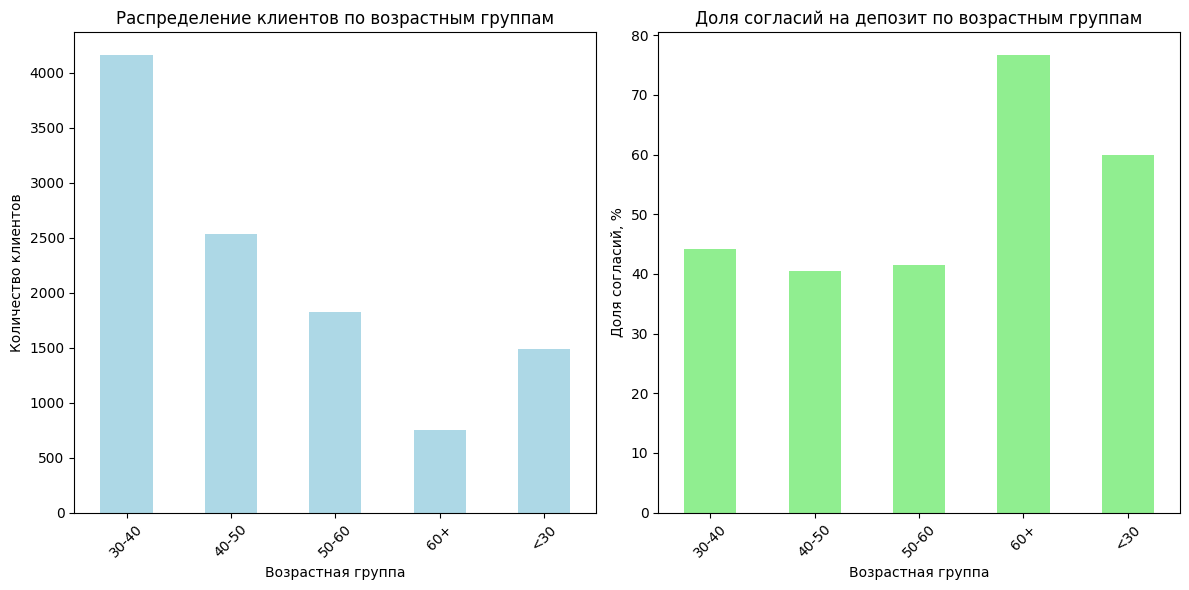


Абсолютные числа по возрастным группам:
           Отказ  Согласие
age_group                 
30-40       2325      1834
40-50       1508      1023
50-60       1068       758
60+          175       575
<30          596       893


In [194]:
#Создаем функцию для категоризации возраста
def age_category(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'
#Создаем новую переменную с возрастными категориями
df['age_group'] = df['age'].apply(age_category)
# Проверяем результат
print("Распределение по возрастным группам:")
print(df['age_group'].value_counts().sort_index())
#Анализируем долю согласий на депозит по возрастным группам
age_group_deposit = df.groupby('age_group')['deposit'].value_counts(normalize=True).unstack() * 100
age_group_deposit.columns = ['Отказ (%)', 'Согласие (%)']
print("\nДоля согласий на депозит по возрастным группам:")
print(age_group_deposit.round(2))
#Визуализация
plt.figure(figsize=(12, 6))
#Количество клиентов по возрастным группам
plt.subplot(1, 2, 1)
df['age_group'].value_counts().sort_index().plot(kind='bar', color='lightblue')
plt.title('Распределение клиентов по возрастным группам')
plt.ylabel('Количество клиентов')
plt.xlabel('Возрастная группа')
plt.xticks(rotation=45)
#Доля согласий по возрастным группам
plt.subplot(1, 2, 2)
age_group_deposit['Согласие (%)'].plot(kind='bar', color='lightgreen')
plt.title('Доля согласий на депозит по возрастным группам')
plt.ylabel('Доля согласий, %')
plt.xlabel('Возрастная группа')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#Дополнительный анализ: абсолютные числа
age_group_counts = df.groupby(['age_group', 'deposit']).size().unstack()
age_group_counts.columns = ['Отказ', 'Согласие']
print("\nАбсолютные числа по возрастным группам:")
print(age_group_counts)

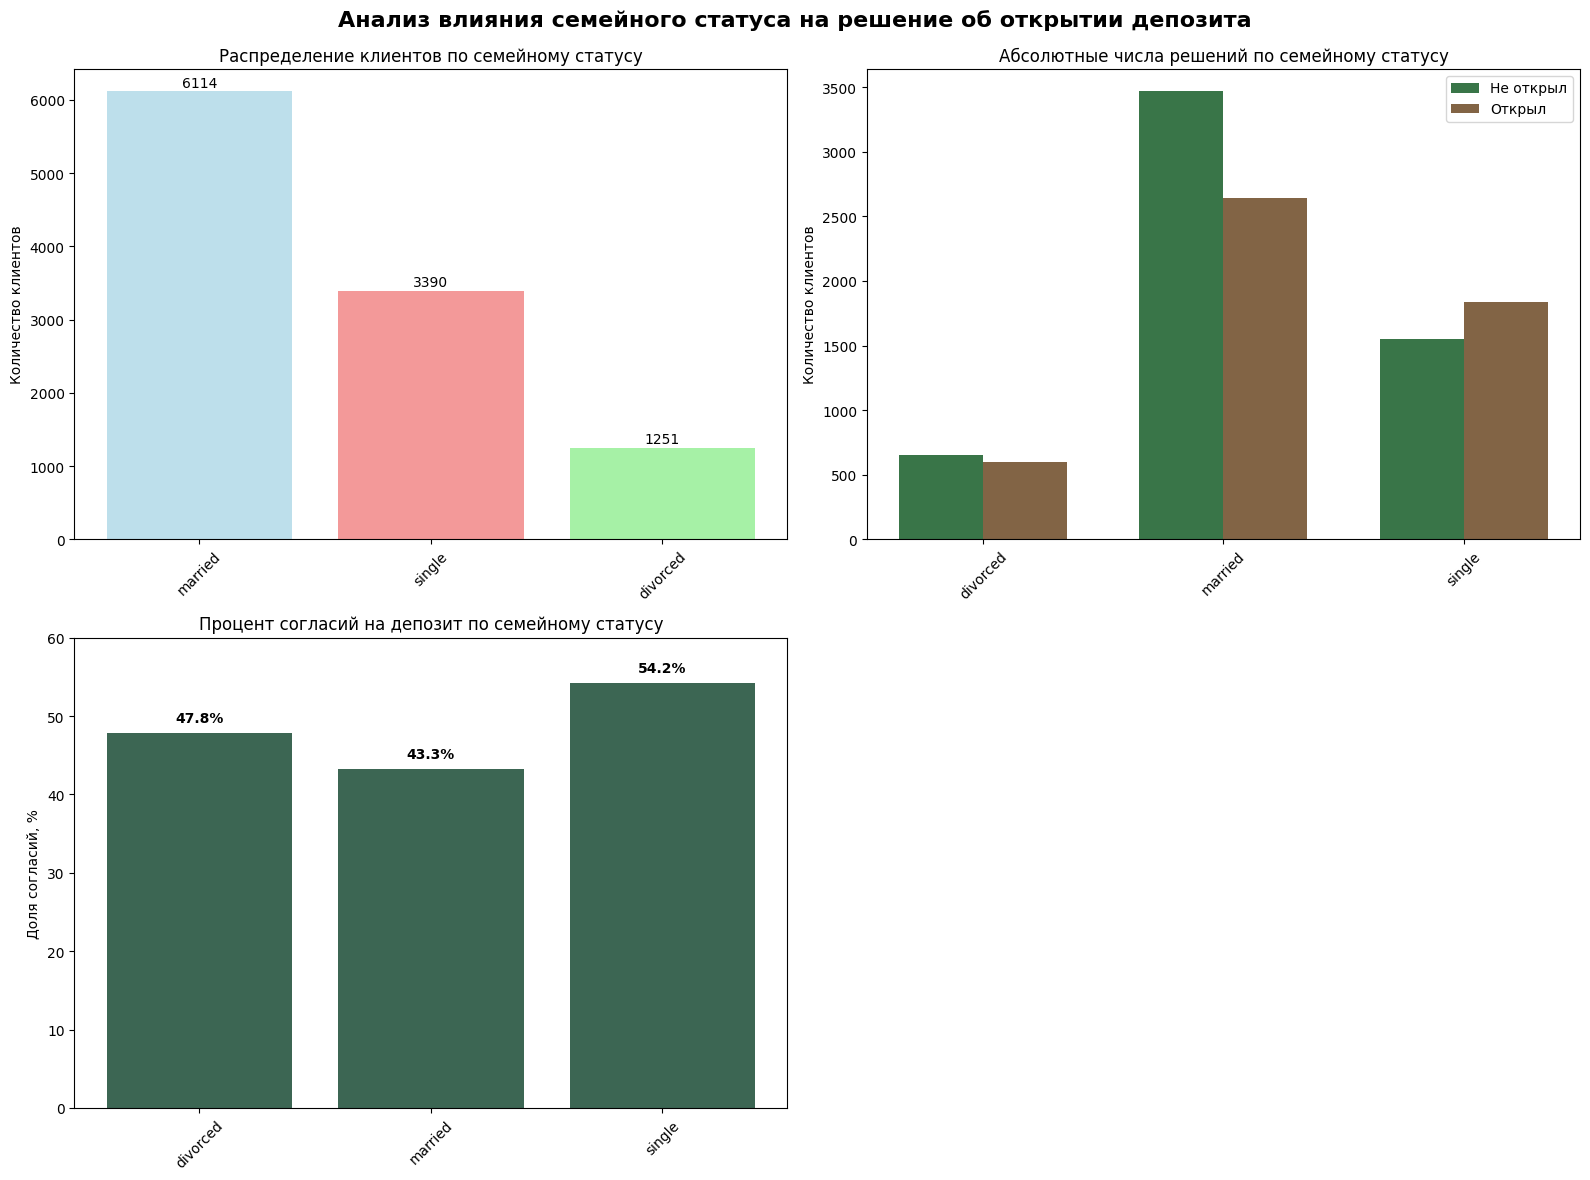

In [195]:
#Создаем отдельные графики для лучшей читаемости
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ влияния семейного статуса на решение об открытии депозита', fontsize=16, fontweight='bold')
#Количество клиентов по семейному статусу
marital_counts = df['marital'].value_counts()
colors1 = ['lightblue', 'lightcoral', 'lightgreen']
ax1.bar(marital_counts.index, marital_counts.values, color=colors1, alpha=0.8)
ax1.set_title('Распределение клиентов по семейному статусу')
ax1.set_ylabel('Количество клиентов')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(marital_counts.values):
    ax1.text(i, v + 20, str(v), ha='center', va='bottom')
#Абсолютные числа по решениям
marital_deposit_count = pd.crosstab(df['marital'], df['deposit'])
colors2 = ["#07521A", "#633D16"]
x = np.arange(len(marital_deposit_count.index))
width = 0.35
ax2.bar(x - width/2, marital_deposit_count['no'], width, label='Не открыл', color=colors2[0], alpha=0.8)
ax2.bar(x + width/2, marital_deposit_count['yes'], width, label='Открыл', color=colors2[1], alpha=0.8)
ax2.set_title('Абсолютные числа решений по семейному статусу')
ax2.set_ylabel('Количество клиентов')
ax2.set_xticks(x)
ax2.set_xticklabels(marital_deposit_count.index)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)
#Доля согласий в процентах
marital_deposit_norm = pd.crosstab(df['marital'], df['deposit'], normalize='index') * 100
colors3 = ["#12233D", "#0B4028"]
ax3.bar(marital_deposit_norm.index, marital_deposit_norm['yes'], color=colors3[1], alpha=0.8)
ax3.set_title('Процент согласий на депозит по семейному статусу')
ax3.set_ylabel('Доля согласий, %')
ax3.set_ylim(0, 60)
ax3.tick_params(axis='x', rotation=45)
for i, v in enumerate(marital_deposit_norm['yes']):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
#Круговые диаграммы для каждого статуса (в виде subplot'ов внутри subplot'а)
statuses = df['marital'].unique()
colors_pie = ["#679E0F", "#56654E"]
for i, status in enumerate(statuses):
    status_data = df[df['marital'] == status]
    deposit_counts = status_data['deposit'].value_counts()
    #Создаем вложенные subplot'ы для круговых диаграмм
    inner_ax = ax4.inset_axes([i*0.32, 0.6, 0.25, 0.25]) if i < 2 else ax4.inset_axes([(i-2)*0.32, 0.1, 0.25, 0.25])
    
    wedges, texts, autotexts = inner_ax.pie(deposit_counts.values, 
                                           labels=deposit_counts.index, 
                                           autopct='%1.1f%%',
                                           colors=colors_pie,
                                           startangle=90,
                                           textprops={'fontsize': 8})
    inner_ax.set_title(f'{status}', fontsize=10, fontweight='bold')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
ax4.set_visible(False)  #Скрываем основной ax4, оставляя только вставленные
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

posx and posy should be finite values
posx and posy should be finite values


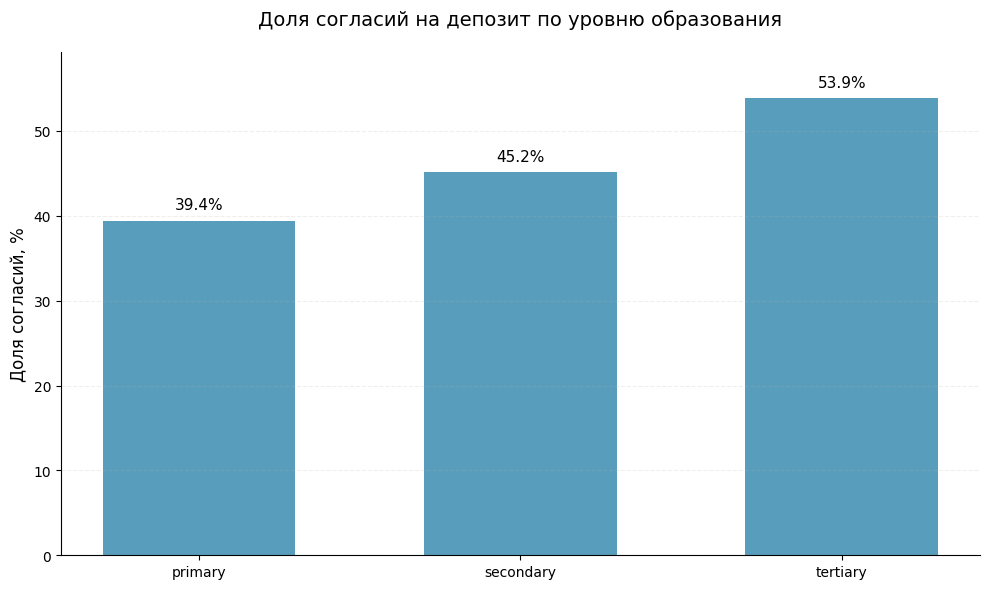

In [196]:
#Визуализация зависимости решения о депозите от уровня образования
plt.figure(figsize=(10, 6))
#Создаем таблицу с долями согласий
education_deposit_norm = pd.crosstab(df['education'], df['deposit'], normalize='index') * 100
education_order = ['primary', 'secondary', 'tertiary', 'unknown']
education_deposit_norm = education_deposit_norm.reindex(education_order)
#Строим барплот
bars = plt.bar(education_deposit_norm.index, 
               education_deposit_norm['yes'], 
               color='#2E86AB', 
               alpha=0.8,
                width=0.6)
#Настройки стиля
plt.title('Доля согласий на депозит по уровню образования', fontsize=14, pad=20)
plt.ylabel('Доля согласий, %', fontsize=12)
plt.ylim(0, max(education_deposit_norm['yes']) * 1.1)
#Убираем лишние элементы
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', alpha=0.2, linestyle='--')
#Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{height:.1f}%', 
             ha='center', 
             va='bottom',
             fontsize=11)
plt.tight_layout()
plt.show()

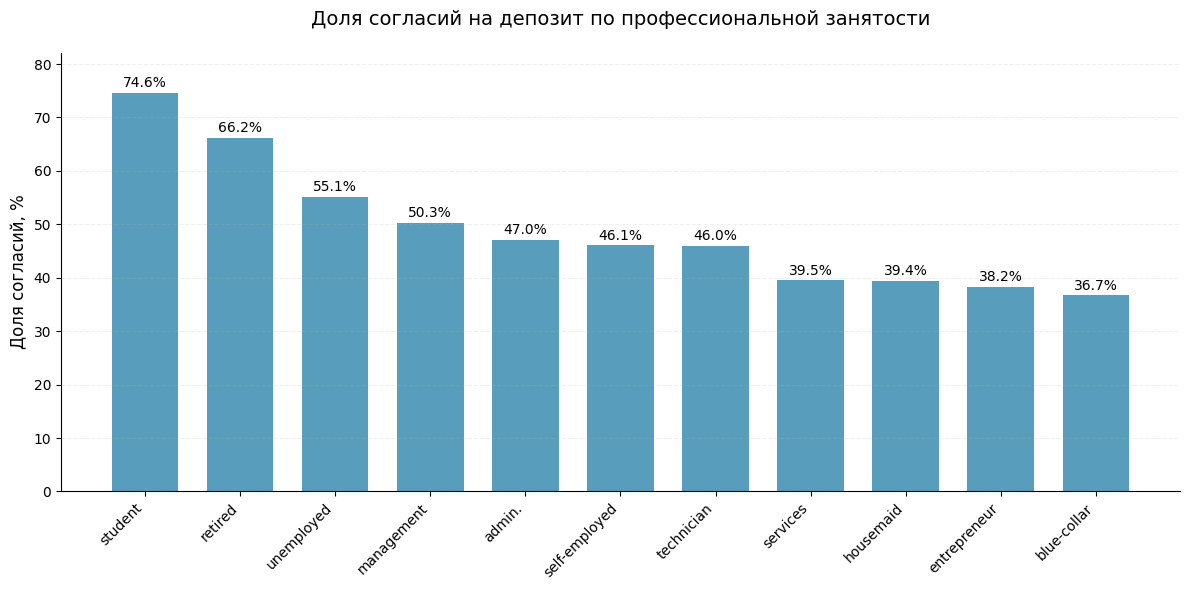

In [197]:
#Визуализация зависимости решения о депозите от профессиональной занятости
plt.figure(figsize=(12, 6))
#Создаем таблицу с долями согласий
job_deposit_norm = pd.crosstab(df['job'], df['deposit'], normalize='index') * 100
#Сортируем по убыванию доли согласий
job_deposit_norm = job_deposit_norm.sort_values('yes', ascending=False)
#Строим барплот
bars = plt.bar(job_deposit_norm.index, 
               job_deposit_norm['yes'], 
               color='#2E86AB', 
               alpha=0.8,
               width=0.7)
#Настройки стиля
plt.title('Доля согласий на депозит по профессиональной занятости', fontsize=14, pad=20)
plt.ylabel('Доля согласий, %', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(job_deposit_norm['yes']) * 1.1)
#Убираем лишние элементы
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', alpha=0.2, linestyle='--')
#Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, 
             f'{height:.1f}%', 
             ha='center', 
             va='bottom',
             fontsize=10)
plt.tight_layout()
plt.show()

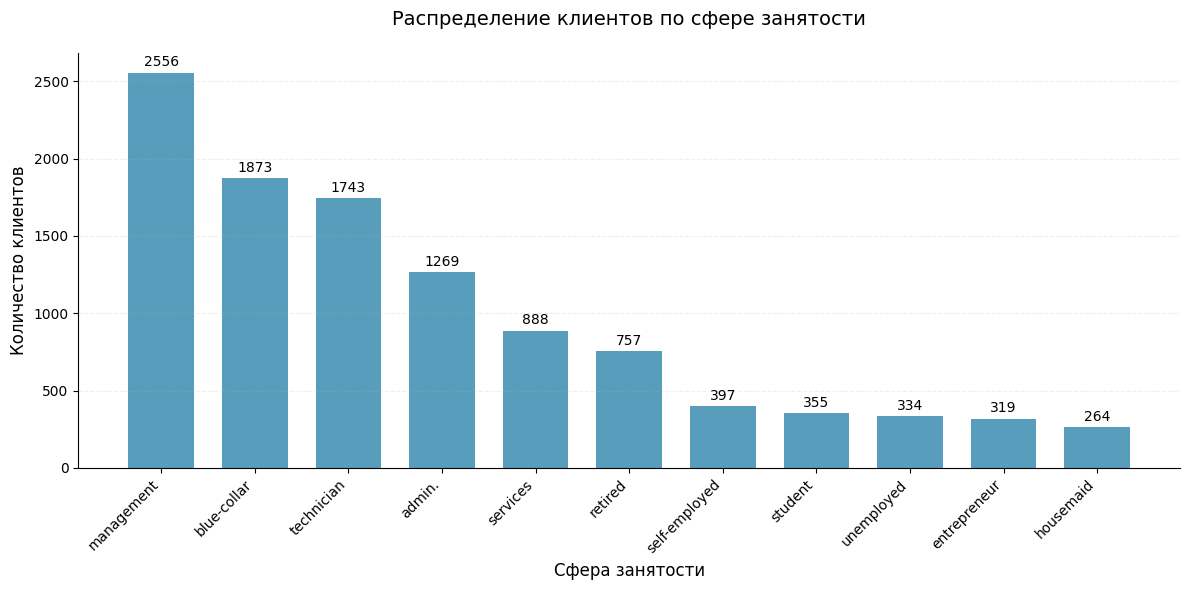


Наибольшее число клиентов банка работает в сфере: management
Количество клиентов: 2556


In [198]:
#Анализ сферы занятости клиентов банка
plt.figure(figsize=(12, 6))
#Считаем количество клиентов по сферам занятости
job_counts = df['job'].value_counts()
#Строим барплот
bars = plt.bar(job_counts.index, 
               job_counts.values, 
               color='#2E86AB', 
               alpha=0.8,
               width=0.7)
#Настройки стиля
plt.title('Распределение клиентов по сфере занятости', fontsize=14, pad=20)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xlabel('Сфера занятости', fontsize=12)
plt.xticks(rotation=45, ha='right')
#Убираем лишние элементы
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', alpha=0.2, linestyle='--')
#Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20, 
             f'{int(height)}', 
             ha='center', 
             va='bottom',
             fontsize=10)
plt.tight_layout()
plt.show()
#Находим сферу с наибольшим числом клиентов
most_common_job = job_counts.idxmax()
most_common_count = job_counts.max()
print(f"\nНаибольшее число клиентов банка работает в сфере: {most_common_job}")
print(f"Количество клиентов: {most_common_count}")

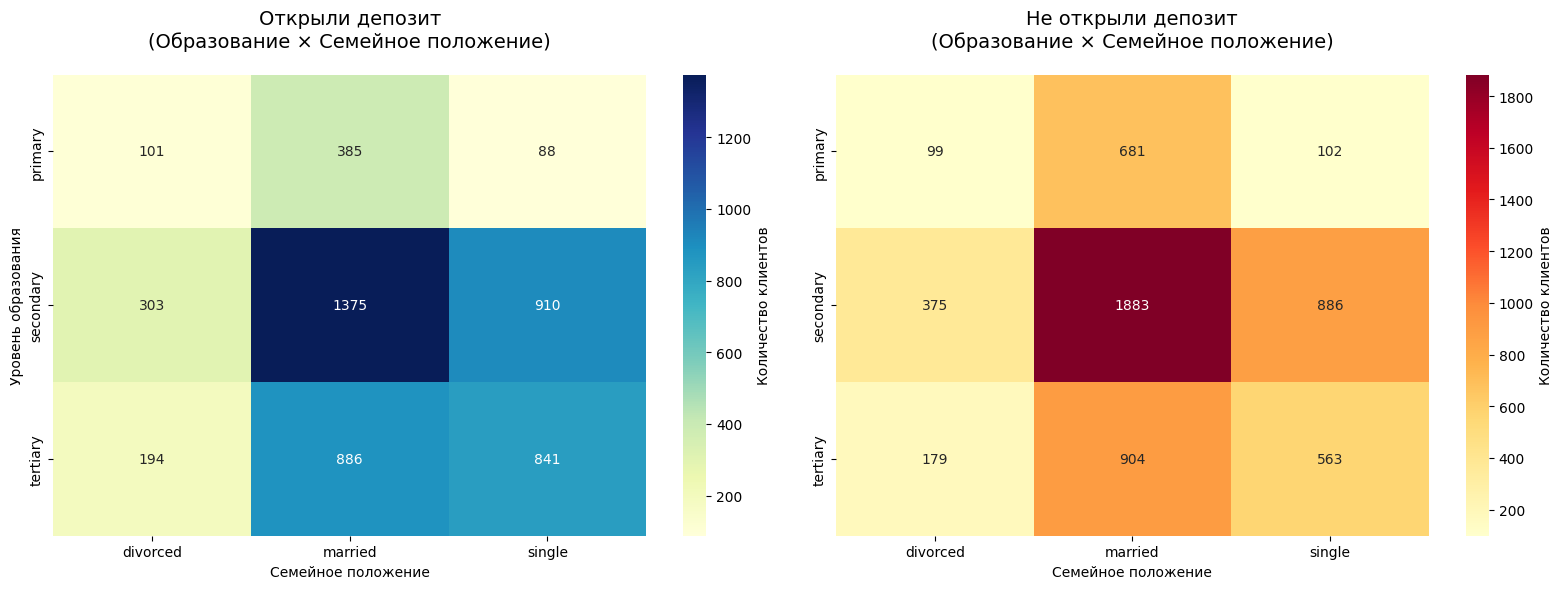

Самые многочисленные среди ОТКРЫВШИХ депозит:
  - Образование: secondary
  - Семейное положение: married
  - Количество: 1375 человек

Самые многочисленные среди НЕ ОТКРЫВШИХ депозит:
  - Образование: secondary
  - Семейное положение: married
  - Количество: 1883 человек


In [199]:
#Создаем тепловые карты для пересечения образования и семейного положения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
#Разделяем данные на открывших и не открывших депозит
deposit_yes = df[df['deposit'] == 'yes']
deposit_no = df[df['deposit'] == 'no']
#Создаем сводные таблицы
pivot_yes = pd.crosstab(deposit_yes['education'], deposit_yes['marital'])
pivot_no = pd.crosstab(deposit_no['education'], deposit_no['marital'])
#Тепловая карта для открывших депозит
sns.heatmap(pivot_yes, annot=True, fmt='d', cmap='YlGnBu', ax=ax1, cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Открыли депозит\n(Образование × Семейное положение)', fontsize=14, pad=20)
ax1.set_xlabel('Семейное положение')
ax1.set_ylabel('Уровень образования')
#Тепловая карта для не открывших депозит
sns.heatmap(pivot_no, annot=True, fmt='d', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Количество клиентов'})
ax2.set_title('Не открыли депозит\n(Образование × Семейное положение)', fontsize=14, pad=20)
ax2.set_xlabel('Семейное положение')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()
#Для открывших депозит
max_yes = pivot_yes.max().max()
max_yes_index = pivot_yes.stack().idxmax()
print(f"Самые многочисленные среди ОТКРЫВШИХ депозит:")
print(f"  - Образование: {max_yes_index[0]}")
print(f"  - Семейное положение: {max_yes_index[1]}")
print(f"  - Количество: {max_yes} человек")
#Для не открывших депозит
max_no = pivot_no.max().max()
max_no_index = pivot_no.stack().idxmax()
print(f"\nСамые многочисленные среди НЕ ОТКРЫВШИХ депозит:")
print(f"  - Образование: {max_no_index[0]}")
print(f"  - Семейное положение: {max_no_index[1]}")
print(f"  - Количество: {max_no} человек")

## Преобразование данных

In [200]:
#Обработка категориального порядкового признака education с помощью LabelEncoder
from sklearn.preprocessing import LabelEncoder
#Проверяем текущие значения признака education
print("Уникальные значения education до кодирования:")
print(df['education'].unique())
print("\nРаспределение значений education:")
print(df['education'].value_counts())
#Создаем экземпляр LabelEncoder
education_encoder = LabelEncoder()
#Применяем LabelEncoder к признаку education
df['education_encoded'] = education_encoder.fit_transform(df['education'])
# Проверяем результат кодирования
print("\nРезультат кодирования education:")
print(pd.DataFrame({
    'original': df['education'],
    'encoded': df['education_encoded']
}).drop_duplicates().sort_values('encoded'))
#Удаляем исходный столбец education
df = df.drop('education', axis=1)
print(f"\nРазмерность данных после обработки education: {df.shape}")
print(f"Обновленные названия признаков: {df.columns.tolist()}")
#Проверяем распределение закодированных значений
print("\nРаспределение закодированных значений education:")
print(df['education_encoded'].value_counts().sort_index())
#Сохраняем mapping для интерпретации результатов
education_mapping = dict(zip(education_encoder.classes_, education_encoder.transform(education_encoder.classes_)))
print(f"\nСоответствие значений education: {education_mapping}")

Уникальные значения education до кодирования:
['secondary' 'tertiary' 'primary']

Распределение значений education:
education
secondary    5732
tertiary     3567
primary      1456
Name: count, dtype: int64

Результат кодирования education:
     original  encoded
16    primary        0
0   secondary        1
4    tertiary        2

Размерность данных после обработки education: (10755, 18)
Обновленные названия признаков: ['age', 'job', 'marital', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'balance_value', 'age_group', 'education_encoded']

Распределение закодированных значений education:
education_encoded
0    1456
1    5732
2    3567
Name: count, dtype: int64

Соответствие значений education: {'primary': np.int64(0), 'secondary': np.int64(1), 'tertiary': np.int64(2)}


In [201]:
#Обработка порядкового признака age_group с помощью LabelEncoder
#Создаем функцию для категоризации возраста (как было ранее)
def age_category(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'
#Создаем переменную age_group в наших данных
df['age_group'] = df['age'].apply(age_category)
# Проверяем текущие значения признака age_group
print("Уникальные значения age_group до кодирования:")
print(df['age_group'].unique())
print("\nРаспределение значений age_group:")
print(df['age_group'].value_counts())
#Создаем экземпляр LabelEncoder для age_group
age_group_encoder = LabelEncoder()
#Применяем LabelEncoder к признаку age_group
df['age_group_encoded'] = age_group_encoder.fit_transform(df['age_group'])
#Проверяем результат кодирования
print("\nРезультат кодирования age_group:")
print(pd.DataFrame({
    'original': df['age_group'],
    'encoded': df['age_group_encoded']
}).drop_duplicates().sort_values('encoded'))
#Удаляем исходный столбец age_group
df = df.drop('age_group', axis=1)
print(f"\nРазмерность данных после обработки age_group: {df.shape}")
print(f"Обновленные названия признаков: {df.columns.tolist()}")
#Проверяем распределение закодированных значений
print("\nРаспределение закодированных значений age_group:")
print(df['age_group_encoded'].value_counts().sort_index())
#Сохраняем mapping для интерпретации результатов
age_group_mapping = dict(zip(age_group_encoder.classes_, age_group_encoder.transform(age_group_encoder.classes_)))
print(f"\nСоответствие значений age_group: {age_group_mapping}")
#Находим сумму значений для признака age_group после кодирования
age_group_sum = df['age_group_encoded'].sum()
print(f"\nСумма значений признака age_group после кодирования: {age_group_sum}")

Уникальные значения age_group до кодирования:
['50-60' '40-50' '60+' '30-40' '<30']

Распределение значений age_group:
age_group
30-40    4159
40-50    2531
50-60    1826
<30      1489
60+       750
Name: count, dtype: int64

Результат кодирования age_group:
  original  encoded
8    30-40        0
2    40-50        1
0    50-60        2
7      60+        3
9      <30        4

Размерность данных после обработки age_group: (10755, 18)
Обновленные названия признаков: ['age', 'job', 'marital', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'balance_value', 'education_encoded', 'age_group_encoded']

Распределение закодированных значений age_group:
age_group_encoded
0    4159
1    2531
2    1826
3     750
4    1489
Name: count, dtype: int64

Соответствие значений age_group: {'30-40': np.int64(0), '40-50': np.int64(1), '50-60': np.int64(2), '60+': np.int64(3), '<30': np.int64(4)}

Сумма значений признака age_group 

In [202]:
#Перекодируем целевую переменную deposit в бинарный формат
print("Текущие значения целевой переменной deposit:")
print(df['deposit'].value_counts())
print("\nУникальные значения:")
print(df['deposit'].unique())
#Кодируем целевую переменную: 'no' -> 0, 'yes' -> 1
df['deposit_encoded'] = df['deposit'].map({'no': 0, 'yes': 1})
print("\nРезультат кодирования целевой переменной:")
print(df[['deposit', 'deposit_encoded']].head(10))
print("\nРаспределение после кодирования:")
print(df['deposit_encoded'].value_counts())
print("\nПроверка соответствия:")
print("no -> 0:", (df['deposit'] == 'no').sum(), "записей")
print("yes -> 1:", (df['deposit'] == 'yes').sum(), "записей")
print("Закодировано 0:", (df['deposit_encoded'] == 0).sum(), "записей")
print("Закодировано 1:", (df['deposit_encoded'] == 1).sum(), "записей")
#Проверяем, что кодирование выполнено корректно
assert (df['deposit'] == 'no').sum() == (df['deposit_encoded'] == 0).sum()
assert (df['deposit'] == 'yes').sum() == (df['deposit_encoded'] == 1).sum()
#Обновляем целевую переменную для использования в модели
y = df['deposit_encoded']
print(f"\nИтоговый баланс классов:")
print(f"Класс 0 (не открыли депозит): {y.value_counts()[0]} записей ({y.value_counts(normalize=True)[0]:.1%})")
print(f"Класс 1 (открыли депозит): {y.value_counts()[1]} записей ({y.value_counts(normalize=True)[1]:.1%})")

Текущие значения целевой переменной deposit:
deposit
no     5672
yes    5083
Name: count, dtype: int64

Уникальные значения:
['yes' 'no']

Результат кодирования целевой переменной:
  deposit  deposit_encoded
0     yes                1
1     yes                1
2     yes                1
3     yes                1
4     yes                1
5     yes                1
6     yes                1
7     yes                1
8     yes                1
9     yes                1

Распределение после кодирования:
deposit_encoded
0    5672
1    5083
Name: count, dtype: int64

Проверка соответствия:
no -> 0: 5672 записей
yes -> 1: 5083 записей
Закодировано 0: 5672 записей
Закодировано 1: 5083 записей

Итоговый баланс классов:
Класс 0 (не открыли депозит): 5672 записей (52.7%)
Класс 1 (открыли депозит): 5083 записей (47.3%)


In [203]:
#Перекодируем бинарные переменные: default, housing, loan
binary_variables = ['default', 'housing', 'loan']
print("Текущие значения бинарных переменных:")
for var in binary_variables:
    print(f"\n{var}:")
    print(df[var].value_counts())
    print(f"Уникальные значения: {df[var].unique()}")
#Кодируем бинарные переменные: 'no' -> 0, 'yes' -> 1
for var in binary_variables:
    df[f'{var}_encoded'] = df[var].map({'no': 0, 'yes': 1})
print("\nРезультат кодирования бинарных переменных:")
print(df[binary_variables + [f'{var}_encoded' for var in binary_variables]].head(10))
print("\nРаспределение после кодирования:")
for var in binary_variables:
    print(f"\n{var}_encoded:")
    print(df[f'{var}_encoded'].value_counts())

Текущие значения бинарных переменных:

default:
default
no     10592
yes      163
Name: count, dtype: int64
Уникальные значения: ['no' 'yes']

housing:
housing
no     5674
yes    5081
Name: count, dtype: int64
Уникальные значения: ['yes' 'no']

loan:
loan
no     9342
yes    1413
Name: count, dtype: int64
Уникальные значения: ['no' 'yes']

Результат кодирования бинарных переменных:
  default housing loan  default_encoded  housing_encoded  loan_encoded
0      no     yes   no                0                1             0
1      no      no   no                0                0             0
2      no     yes   no                0                1             0
3      no     yes   no                0                1             0
4      no      no   no                0                0             0
5      no     yes  yes                0                1             1
6      no     yes  yes                0                1             1
7      no     yes   no                0         

In [204]:
#Список номинальных переменных для преобразования
nominal_variables = ['job', 'marital', 'contact', 'month', 'poutcome']
print("Текущие уникальные значения номинальных переменных:")
for var in nominal_variables:
    print(f"\n{var}:")
    print(df[var].value_counts())
    print(f"Уникальные значения: {sorted(df[var].unique())}")
#Создаем и применяем LabelEncoder для каждой переменной
label_encoders = {}
for var in nominal_variables:
    le = LabelEncoder()
    df[f'{var}_encoded'] = le.fit_transform(df[var])
    label_encoders[var] = le  #Сохраняем кодировщик для возможного обратного преобразования
    
    print(f"\n{var}_encoded mapping:")
    for original, encoded in zip(le.classes_, range(len(le.classes_))):
        print(f"  {original} -> {encoded}")
print("\nРезультат кодирования LabelEncoder:")
print(df[[var for var in nominal_variables] + [f'{var}_encoded' for var in nominal_variables]].head(10))
print("\nРаспределение после кодирования:")
for var in nominal_variables:
    print(f"\n{var}_encoded:")
    print(df[f'{var}_encoded'].value_counts().sort_index())

Текущие уникальные значения номинальных переменных:

job:
job
management       2556
blue-collar      1873
technician       1743
admin.           1269
services          888
retired           757
self-employed     397
student           355
unemployed        334
entrepreneur      319
housemaid         264
Name: count, dtype: int64
Уникальные значения: ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed']

marital:
marital
married     6114
single      3390
divorced    1251
Name: count, dtype: int64
Уникальные значения: ['divorced', 'married', 'single']

contact:
contact
cellular     7732
unknown      2267
telephone     756
Name: count, dtype: int64
Уникальные значения: ['cellular', 'telephone', 'unknown']

month:
month
may    2728
aug    1476
jul    1461
jun    1170
nov     916
apr     887
feb     742
oct     373
jan     326
sep     306
mar     268
dec     102
Name: count, dtype: int64
Уникальные 

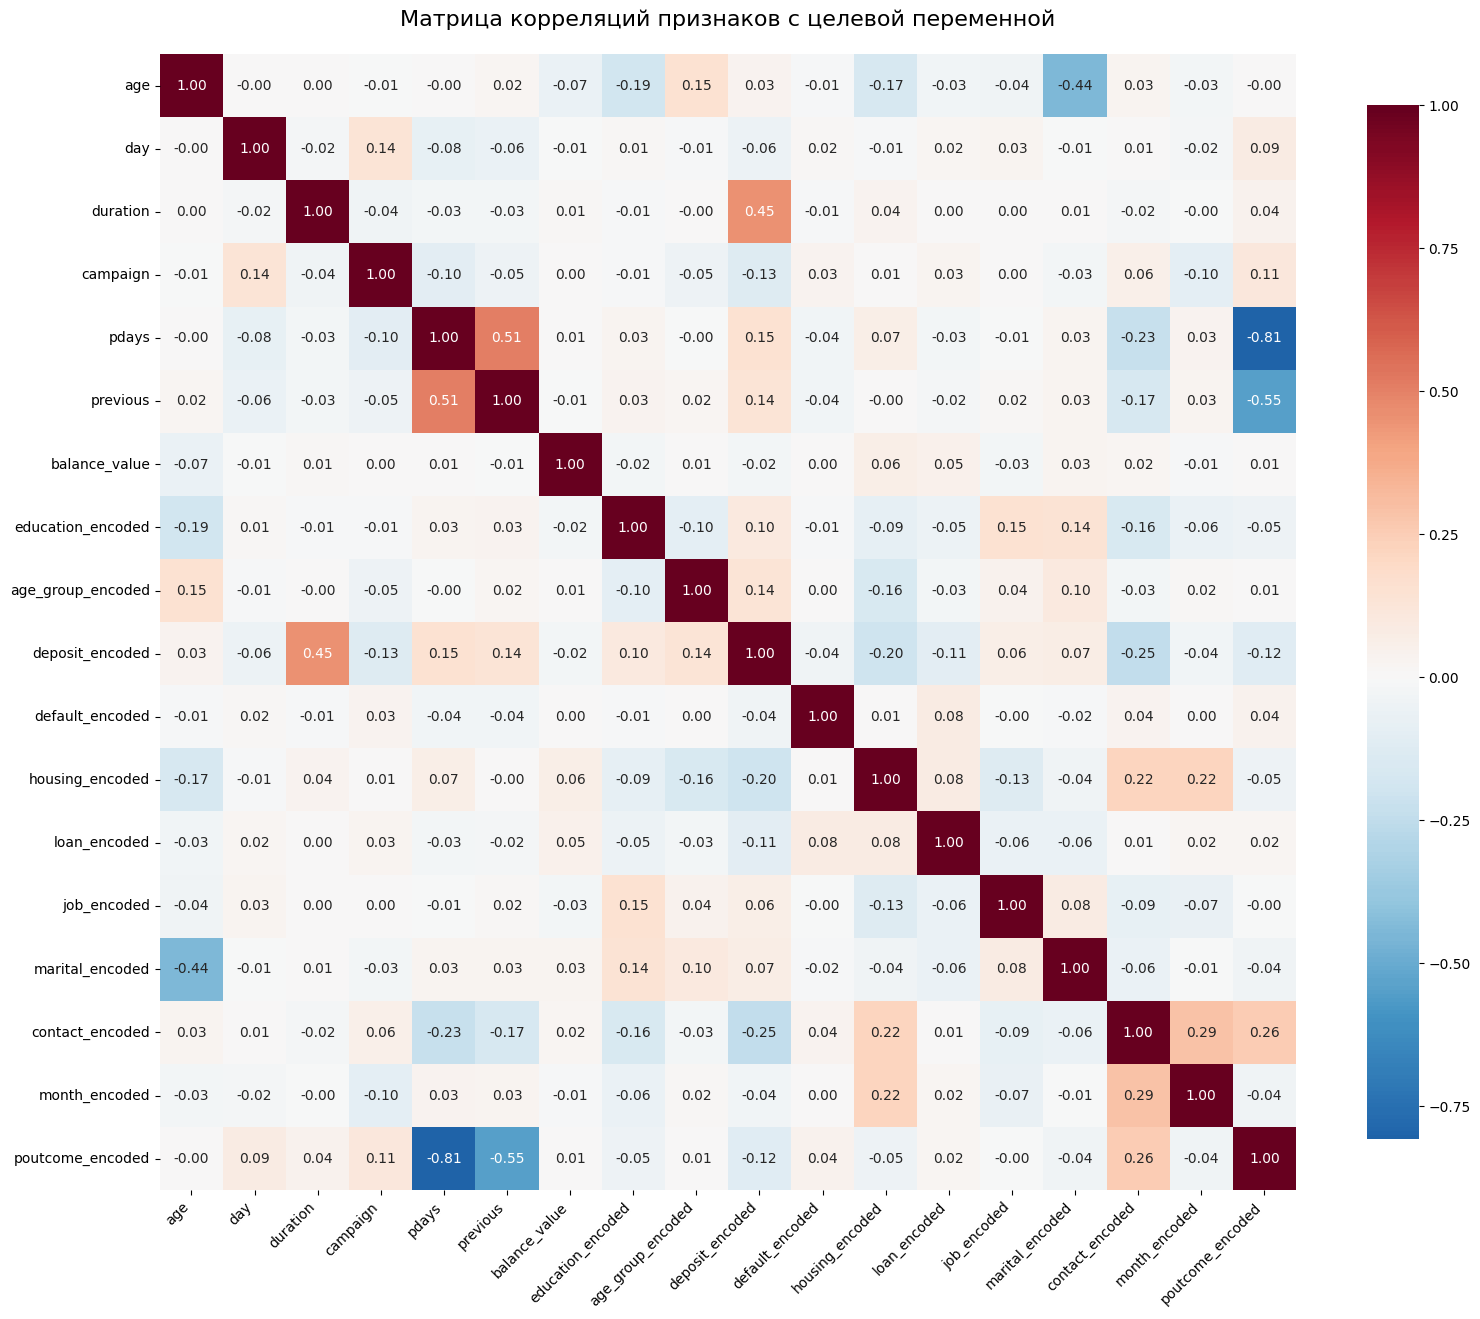

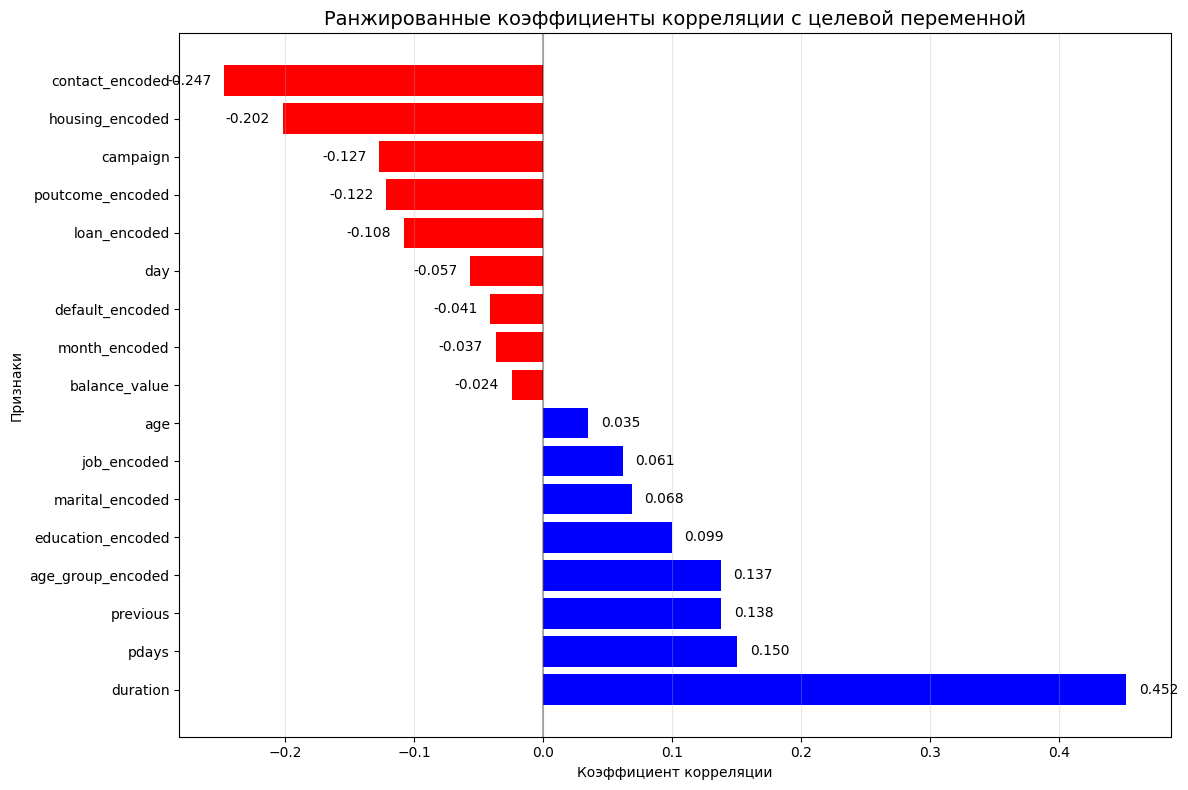

Признаки с высокой корреляцией между собой (|r| > 0.9):
1. duration: 0.452
2. pdays: 0.150
3. previous: 0.138
4. age_group_encoded: 0.137
5. education_encoded: 0.099


In [205]:
#Выберем все числовые переменные (включая закодированные)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
#Создаем матрицу корреляций
correlation_matrix = df[numeric_columns].corr()
#Создаем тепловую карту
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f',
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций признаков с целевой переменной', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
#Создаем столбчатую диаграмму для ранжированных коэффициентов корреляции с целевой переменной
target_correlations = correlation_matrix['deposit_encoded'].drop('deposit_encoded').sort_values(ascending=False)
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in target_correlations.values]
bars = plt.barh(target_correlations.index, target_correlations.values, color=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Признаки')
plt.title('Ранжированные коэффициенты корреляции с целевой переменной', fontsize=14)
plt.grid(axis='x', alpha=0.3)
#Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    if width >= 0:
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    else:
        plt.text(width - 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='right', va='center')
plt.tight_layout()
plt.show()
#Анализ мультиколлинеарности
print("Признаки с высокой корреляцией между собой (|r| > 0.9):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9 and correlation_matrix.columns[i] != correlation_matrix.columns[j]:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], 
                                  correlation_matrix.iloc[i, j]))
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
for i, (feature, corr) in enumerate(target_correlations.head(5).items(), 1):
    print(f"{i}. {feature}: {corr:.3f}")

### Разделение на выборки

In [206]:
df = df.drop(['age', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 
              'job', 'marital', 'deposit'],axis=1)

In [207]:
X = df.drop(['deposit_encoded'], axis=1)
y = df['deposit_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Общая информация о выборках и датасете

In [208]:
#Статистические показатели для всего датасета
print(f"Общее количество наблюдений: {len(df)}")
print(f"Размерность признакового пространства: {X.shape[1]} признаков")
print(f"Целевая переменная распределение:")
print(y.value_counts())
print(f"Доля положительного класса (deposit_encoded = 1): {y.mean():.3f}")
#Статистические показатели для тренировочной выборки
print(f"Размер тренировочной выборки: {len(X_train)} наблюдений ({len(X_train)/len(df)*100:.1f}%)")
print(f"Распределение целевой переменной в train:")
print(y_train.value_counts())
print(f"Доля положительного класса в train: {y_train.mean():.3f}")
#Статистические показатели для тестовой выборки
print(f"Размер тестовой выборки: {len(X_test)} наблюдений ({len(X_test)/len(df)*100:.1f}%)")
print(f"Распределение целевой переменной в test:")
print(y_test.value_counts())
print(f"Доля положительного класса в test: {y_test.mean():.3f}")
#Проверка стратификации
print(f"Доля positive класса в исходных данных: {y.mean():.4f}")
print(f"Доля positive класса в train: {y_train.mean():.4f}")
print(f"Доля positive класса в test: {y_test.mean():.4f}")
print(f"Разница в долях: {abs(y_train.mean() - y_test.mean()):.6f}")
#Описательная статистика признаков
print(X_train.describe())
#Проверка на пропущенные значения
print("Пропущенные значения в X_train:")
print(X_train.isnull().sum())
print("\nПропущенные значения в X_test:")
print(X_test.isnull().sum())
#Информация о типах данных
print("Типы данных в X_train:")
print(X_train.dtypes)
#Баланс классов
train_class_ratio = y_train.value_counts(normalize=True)
test_class_ratio = y_test.value_counts(normalize=True)
print(f"Train: Class 0 = {train_class_ratio[0]:.3f}, Class 1 = {train_class_ratio[1]:.3f}")
print(f"Test:  Class 0 = {test_class_ratio[0]:.3f}, Class 1 = {test_class_ratio[1]:.3f}")

Общее количество наблюдений: 10755
Размерность признакового пространства: 16 признаков
Целевая переменная распределение:
deposit_encoded
0    5672
1    5083
Name: count, dtype: int64
Доля положительного класса (deposit_encoded = 1): 0.473
Размер тренировочной выборки: 7205 наблюдений (67.0%)
Распределение целевой переменной в train:
deposit_encoded
0    3800
1    3405
Name: count, dtype: int64
Доля положительного класса в train: 0.473
Размер тестовой выборки: 3550 наблюдений (33.0%)
Распределение целевой переменной в test:
deposit_encoded
0    1872
1    1678
Name: count, dtype: int64
Доля положительного класса в test: 0.473
Доля positive класса в исходных данных: 0.4726
Доля positive класса в train: 0.4726
Доля positive класса в test: 0.4727
Разница в долях: 0.000088
          day  duration  campaign   pdays  previous  balance_value  \
count 7205.00   7205.00   7205.00 7205.00   7205.00        7205.00   
mean    15.70    370.68      2.48   51.19      0.84         177.58   
std      8.4